In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import glob
import matplotlib.pyplot as plt
import nilearn.image, nilearn.masking, nilearn.plotting
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import statsmodels.stats.multitest
import nilearn.plotting
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: Fut

In [2]:
data_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02_MO_short_duration/data/'

In [3]:
subj_list = [
    'GA01', 'GA02', 'GA05', 'GA07', 'GA08', 'GA11', 'GA12', 'GA13', 'GA14', 'GA15',
    'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 'GA26', 'GA27', 'GA28', 'GA29', 'GA30',
    'GA31', 'GA32', 'GA33', 'GA34', 'GA35', 'GA36', 'GA37', 'GA38', 'GA42', 'GA44',
    'GB01', 'GB02', 'GB05', 'GB07', 'GB08', 'GB11', 'GB12', 'GB13', 'GB14', 'GB15',
    'GB18', 'GB19', 'GB20', 'GB21', 'GB23', 'GB26', 'GB27', 'GB28', 'GB29', 'GB30',
    'GB31', 'GB32', 'GB33', 'GB34', 'GB35', 'GB36', 'GB37', 'GB38', 'GB42', 'GB44'
]

In [4]:
data = {}

for subj in subj_list:
    for run in range(1, 7):
        data[subj, run] = nilearn.image.load_img(data_dir + 'betasLSS.MO.shortdur.%s.r%02d.nii.gz' % (subj, run))
    print(subj, end='\r')

In [5]:
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [6]:
target_pos = []

with open('/Volumes/clmnlab/GA/MVPA/LSS_pb02/behaviors/targetID.txt') as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]

In [7]:
target_path = list(range(1, 13)) * 8

In [8]:
def fast_masking(img, roi):
    img_data = img.get_data()
    roi_mask = roi.get_data().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [9]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

# ROIs

In [13]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/localizer/'

roi_path = sorted(glob.glob(roi_dir + 'n200_*.nii'))
roi_imgs = {}
roi_names = []

for path in roi_path:
    roi_name = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi_name] = (nilearn.image.load_img(path))
    roi_names.append(roi_name)
    
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    fnames = glob.glob('/Volumes/clmnlab/GA/fmri_data/masks/DMN/%s_*.nii' % (name))
    
    for fname in fnames:
        roi_name = fname.replace('/Volumes/clmnlab/GA/fmri_data/masks/DMN/', '').replace('.nii', '')
        roi_imgs[roi_name] = nilearn.image.load_img(fname)
        roi_names.append(roi_name)

roi_info = pd.read_csv('/Volumes/clmnlab/GA/fmri_data/masks/Fan/20190926/fan_cluster_net_20191010.csv')

for _, row in roi_info.iterrows():
    if row['yeo_17network'] == 1:
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append(row['region'])

In [14]:
roi_names

['n200_c1-1_L_M1',
 'n200_c1-2_L_S1',
 'n200_c1_L_Postcentral',
 'n200_c2_R_CerebellumIV-V',
 'n200_c3_R_Postcentral',
 'n200_c4_L_Putamen',
 'n200_c5_R_SMA',
 'n200_c6_R_CerebellumVIIIb',
 'n200_c7_L_Thalamus',
 'Core_aMPFC_r',
 'Core_aMPFC_l',
 'Core_PCC_l',
 'Core_PCC_r',
 'dMsub_TempP_l_temp',
 'dMsub_LTC_l',
 'dMsub_TPJ_r',
 'dMsub_LTC_r',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'dMsub_TPJ_l',
 'MTLsub_PHC_r',
 'MTLsub_vMPFC',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_HF_l',
 'MTLsub_PHC_l',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_HF_r',
 'FuG_L_3_2',
 'FuG_R_3_2',
 'MVOcC_L_5_1',
 'MVOcC_R_5_1',
 'MVOcC_L_5_3',
 'MVOcC_R_5_3',
 'MVOcC_R_5_4',
 'LOcC_L_4_1',
 'LOcC_R_4_1',
 'LOcC_L_4_3',
 'LOcC_R_4_3',
 'LOcC_L_4_4',
 'LOcC_R_4_4',
 'LOcC_L_2_2']

In [15]:
results = {}

for subj in subj_list:
    for name, roi_img in roi_imgs.items():
        if ('pos', 'unpracticed', subj, name) in results:
            continue
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]
        
        results['pos', 'practiced', subj, name] = cross_validation(X, target_pos)
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]
        
        results['pos', 'unpracticed', subj, name] = cross_validation(X, target_pos)
        
        print(subj, name, end='\r')

In [16]:
with open('20200316_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [ ]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Consistency', 'Reward', 'Stage'])

for subj in subj_list[:30]:
    for i, roi_name in enumerate(roi_names):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

In [ ]:
wit_df.head()

In [16]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1  True 0.00 -3.96 0.000
       n200_c1-2_L_S1  True 0.00 -4.11 0.000
n200_c1_L_Postcentral  True 0.00 -4.57 0.000


In [17]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1 False 0.05  2.52 0.018
       n200_c1-2_L_S1  True 0.02  3.15 0.004
n200_c1_L_Postcentral  True 0.02  3.15 0.004


In [46]:
sns.set(style="ticks", context='talk')
palette = ['#D9D9D9', '#F23A29']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(8, 8))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding Accuracy')
    #plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

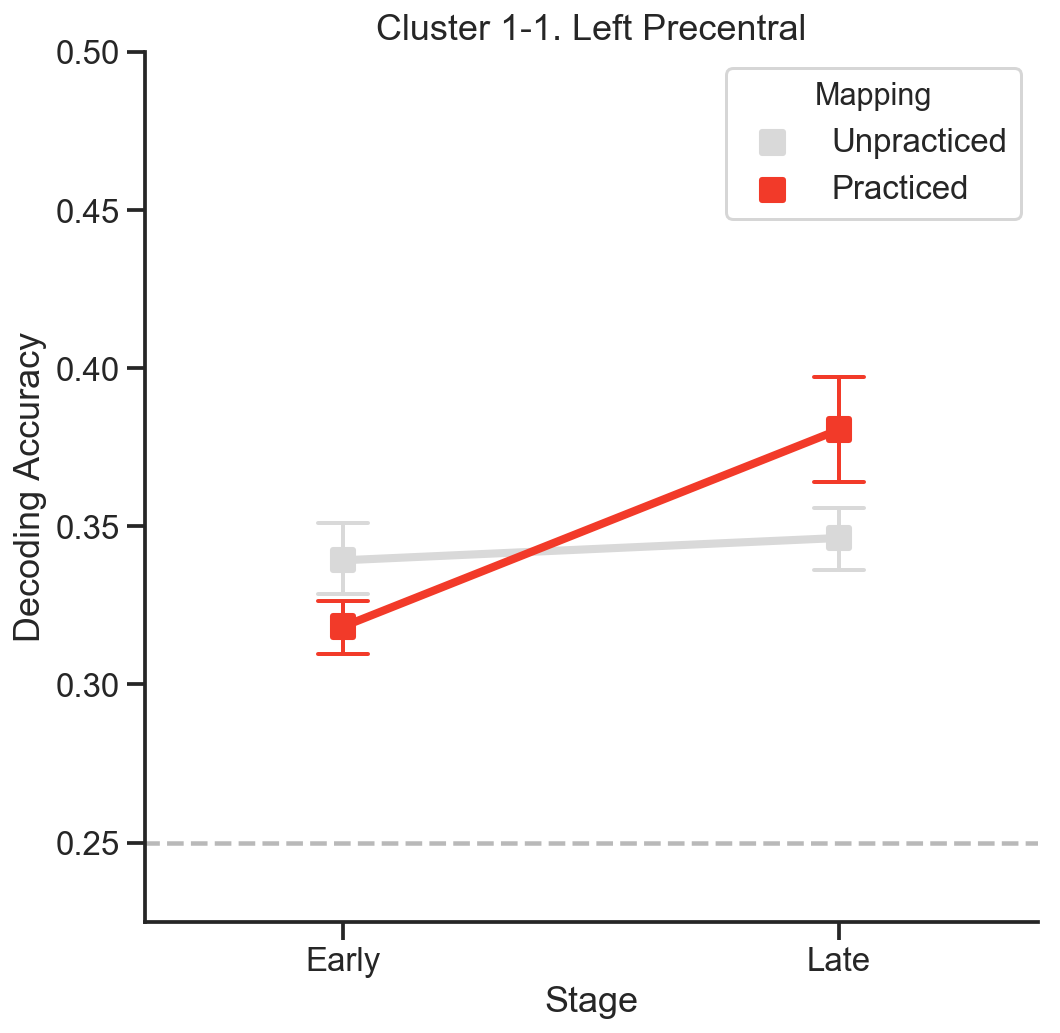

In [26]:
draw_lineplot(roi_names[0], 'Cluster 1-1. Left Precentral')

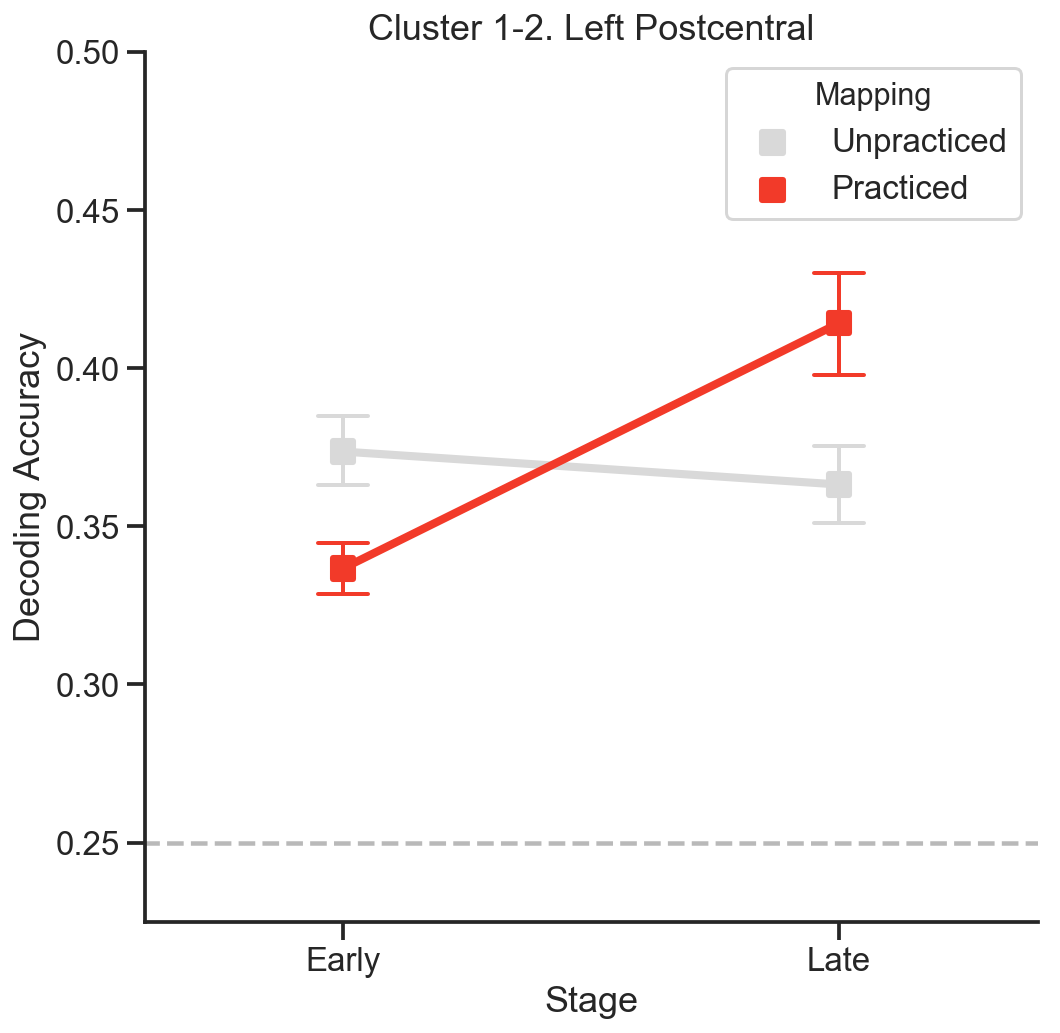

In [27]:
draw_lineplot(roi_names[1], 'Cluster 1-2. Left Postcentral')

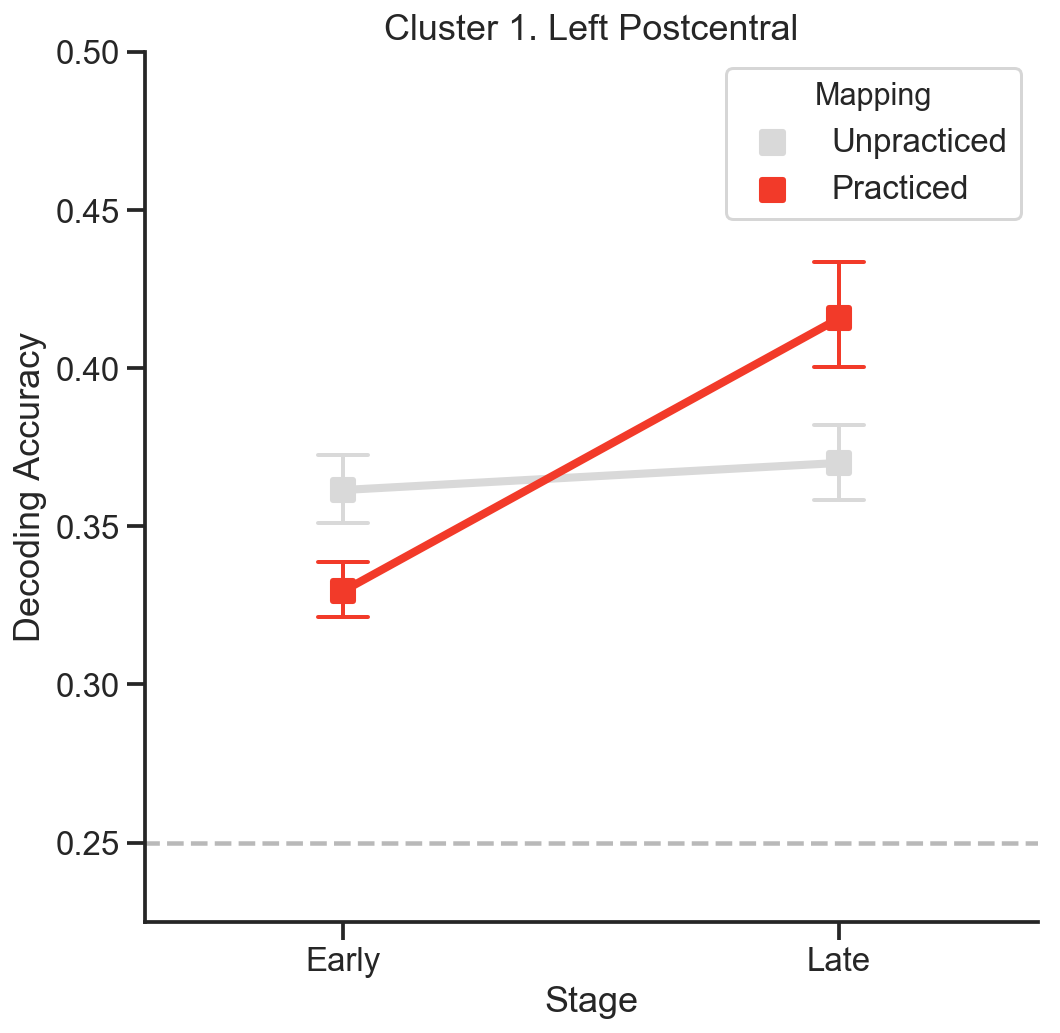

In [28]:
draw_lineplot(roi_names[2], 'Cluster 1. Left Postcentral')

In [29]:
def draw_lineplot(roi_name, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

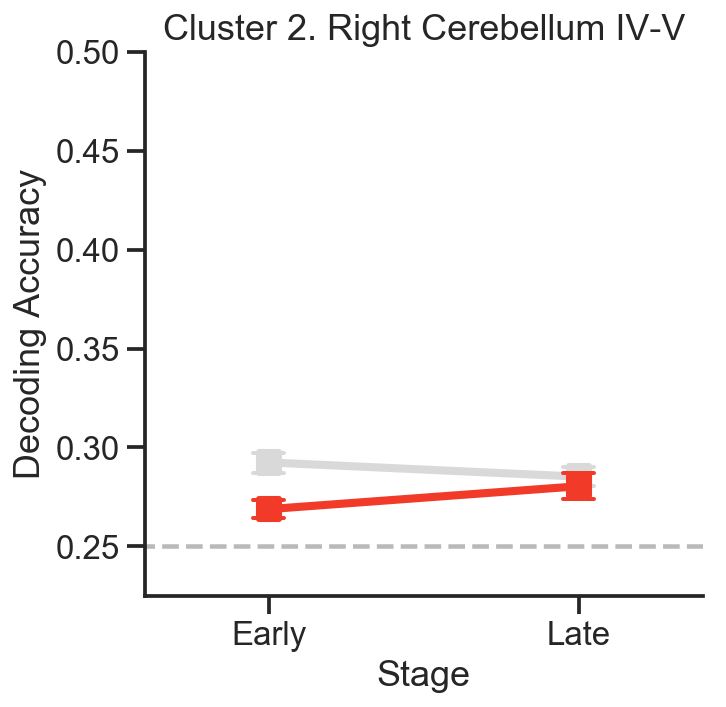

In [30]:
draw_lineplot(roi_names[3], 'Cluster 2. Right Cerebellum IV-V')

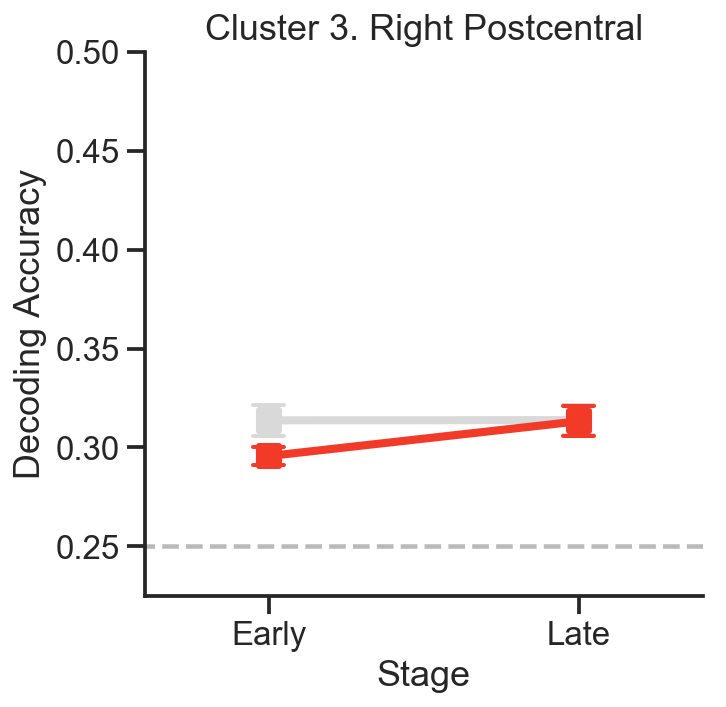

In [31]:
draw_lineplot(roi_names[4], 'Cluster 3. Right Postcentral')

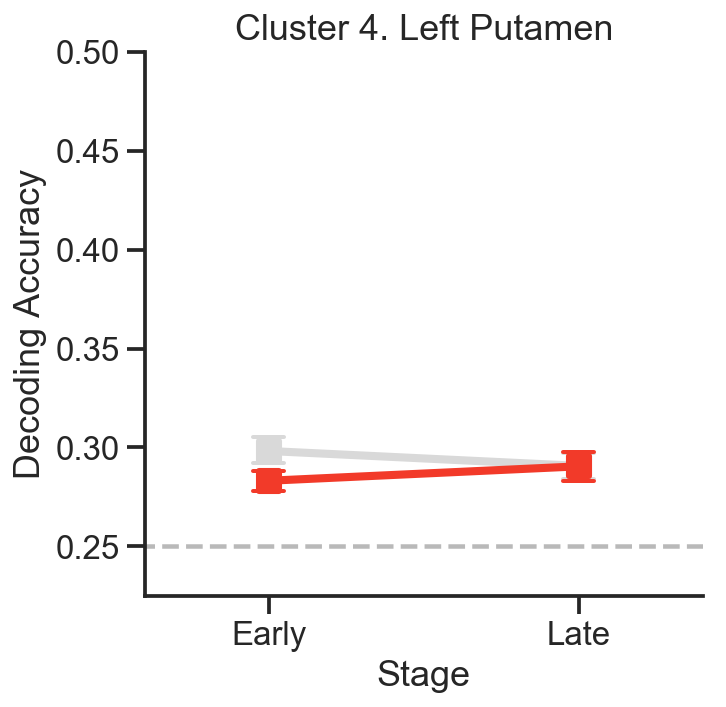

In [32]:
draw_lineplot(roi_names[5], 'Cluster 4. Left Putamen')

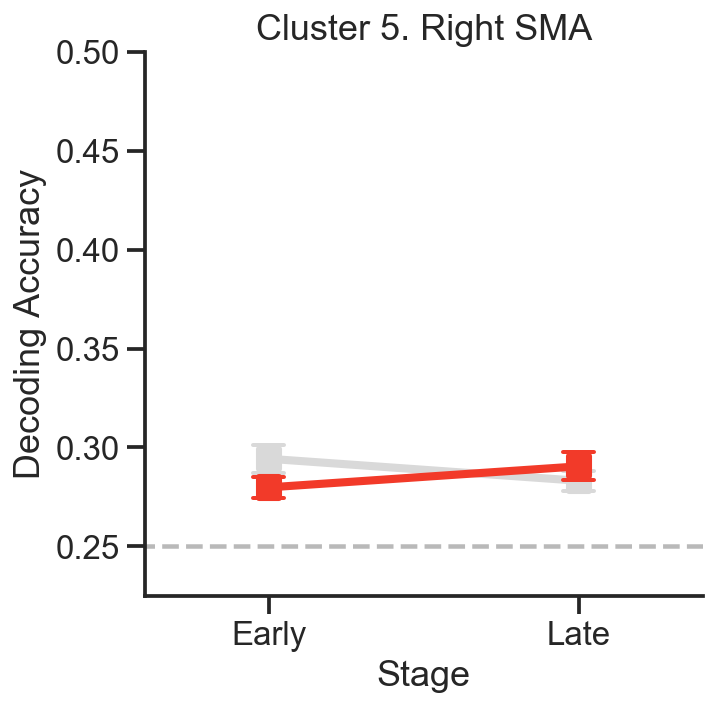

In [33]:
draw_lineplot(roi_names[6], 'Cluster 5. Right SMA')

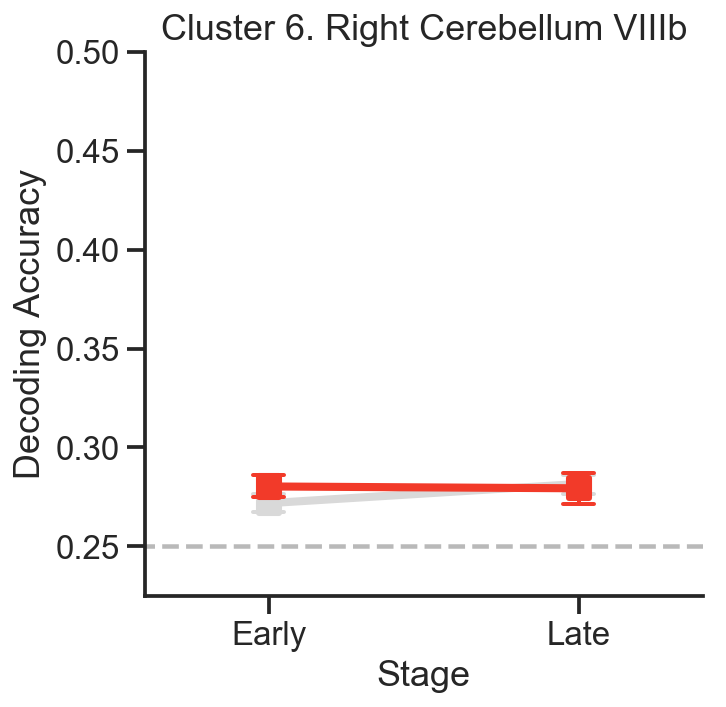

In [34]:
draw_lineplot(roi_names[7], 'Cluster 6. Right Cerebellum VIIIb')

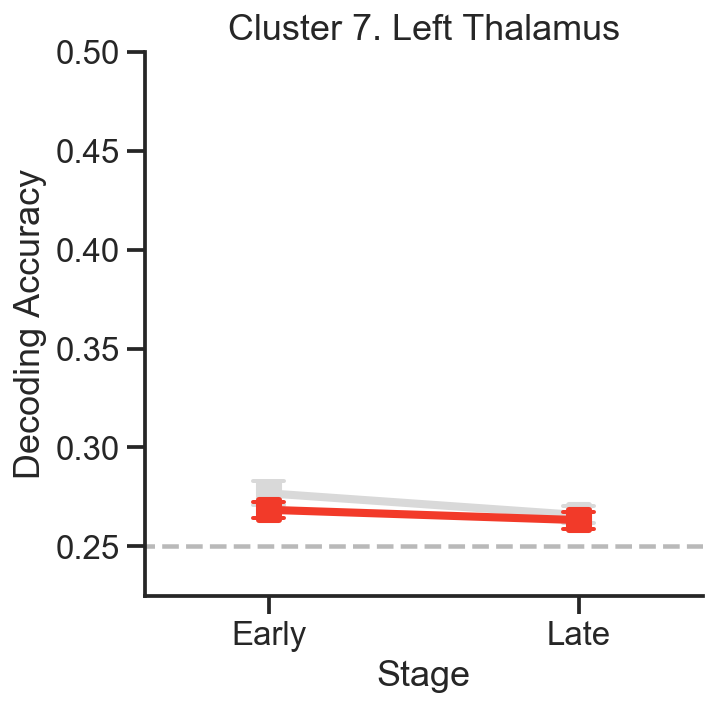

In [35]:
draw_lineplot(roi_names[8], 'Cluster 7. Left Thalamus')

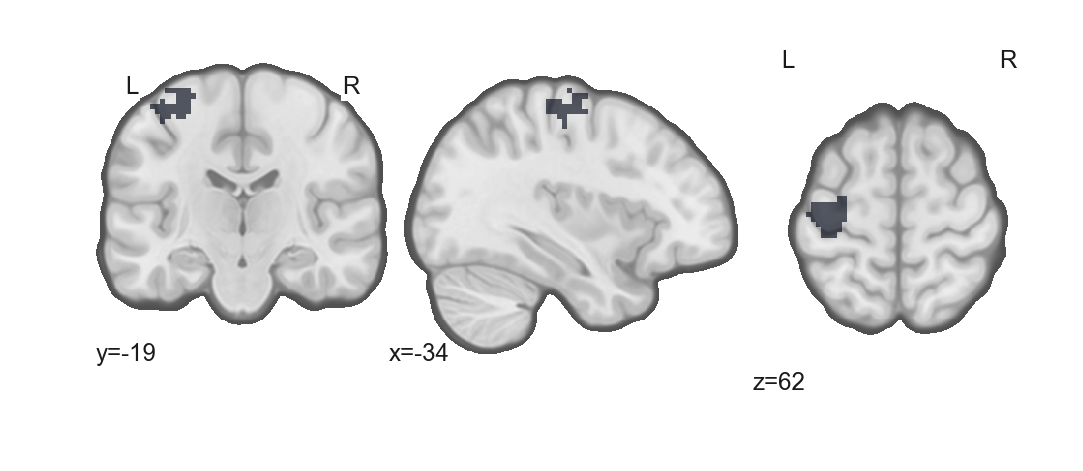

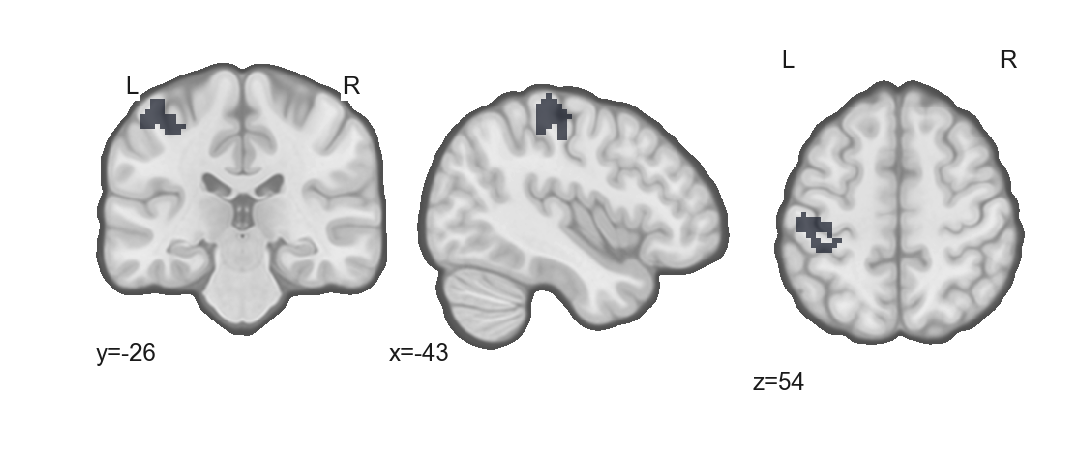

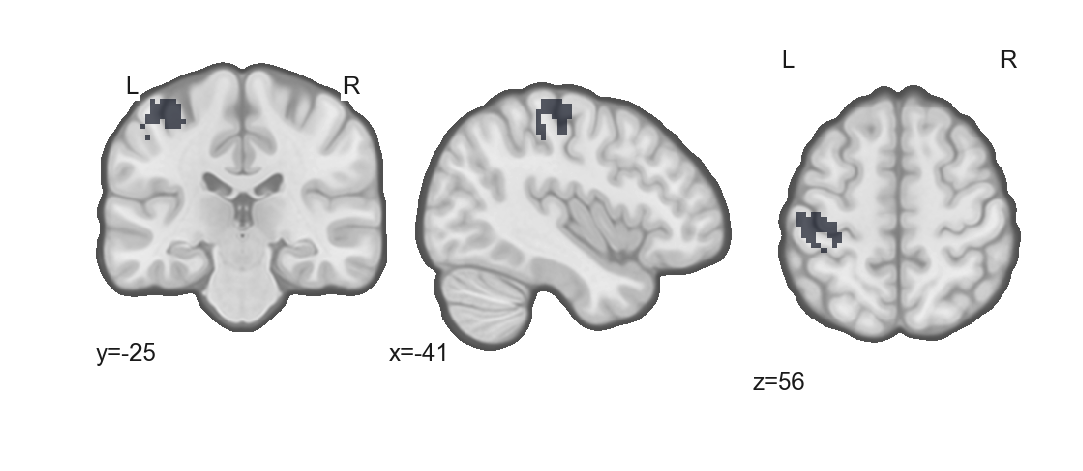

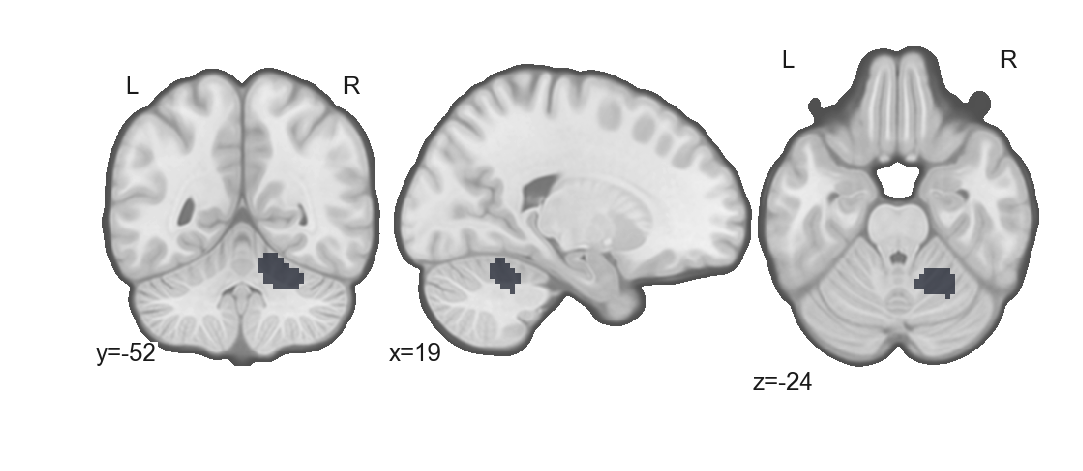

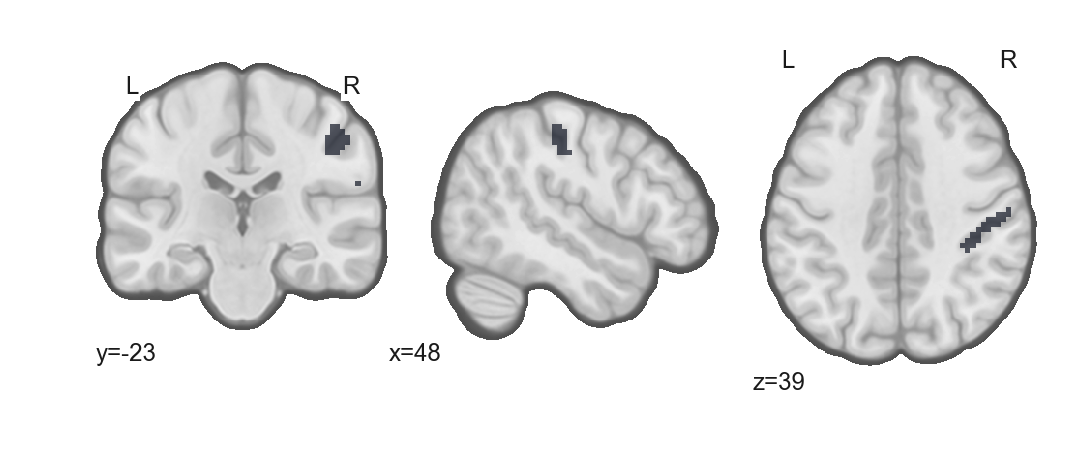

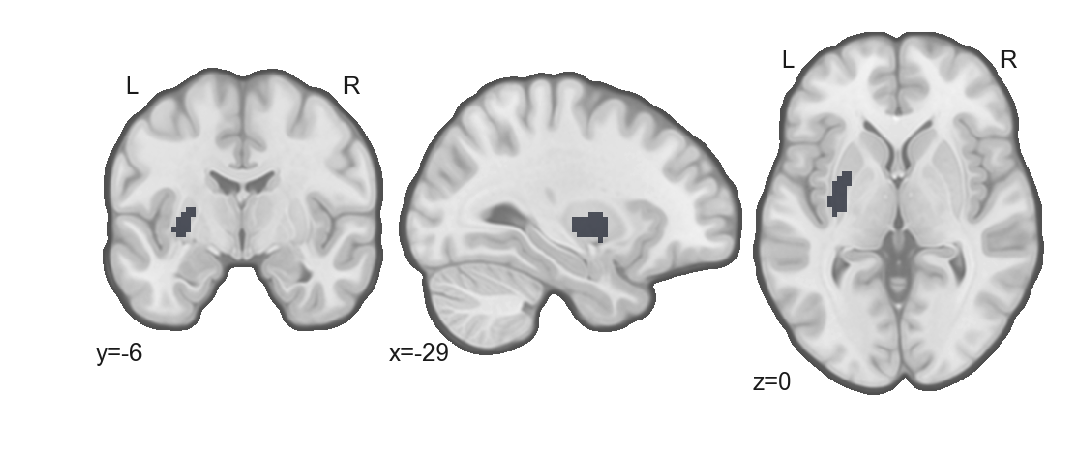

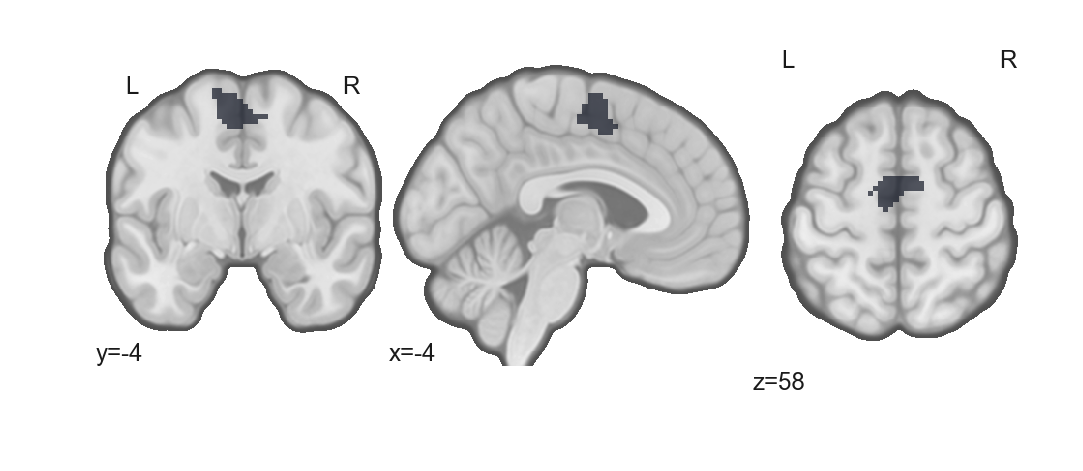

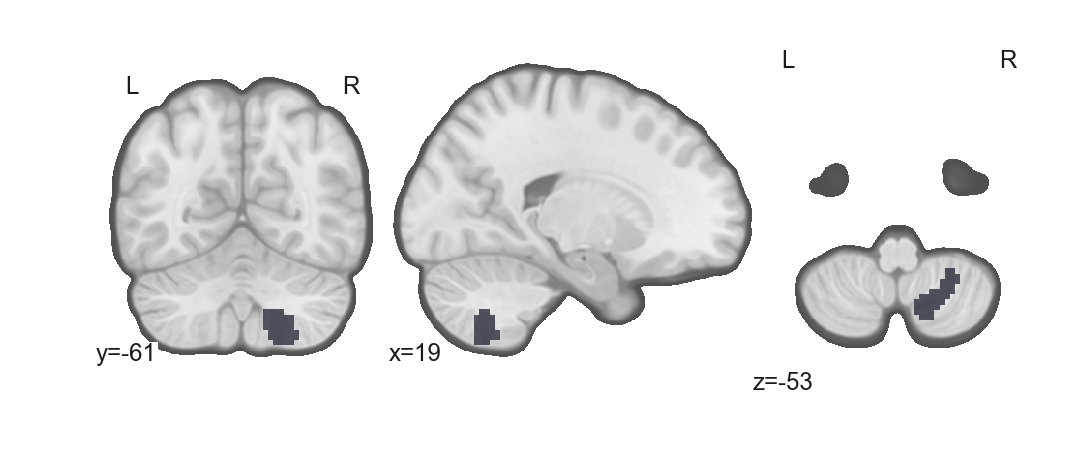

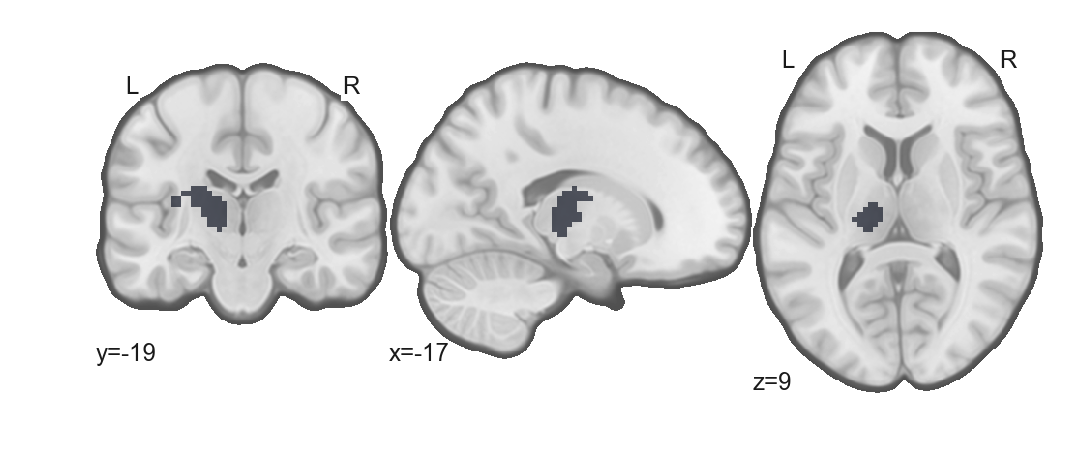

In [45]:
from matplotlib.colors import LinearSegmentedColormap

cm = LinearSegmentedColormap.from_list('GA', [(1, 1, 1), (19/255, 24/255, 38/255)], N=1)

for name in roi_names:
    fig = nilearn.plotting.plot_roi(roi_imgs[name],
                          '/Users/eyshin/Desktop/MRIcroGL/mni152_2009bet.nii.gz', 
                          draw_cross=False, black_bg=False, cmap=cm)
    fig.savefig('20200313_%s.png' % (name), dpi=300)

# DMN whole ROI Decoding accuracy

In [50]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/DMN/'

module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = []
roi_names = []

for name in module_names:
    fnames = glob.glob('%s/%s_*.nii' % (roi_dir, name))
    
    #roi_imgs[name] = {}
    
    for fname in fnames:
        roi_name = fname.replace('/Volumes/clmnlab/GA/fmri_data/masks/DMN/', '').replace('.nii', '')
        roi_imgs.append(nilearn.image.load_img(fname))
        roi_names.append(roi_name)

In [53]:
roi_names

['Core_aMPFC_r',
 'Core_aMPFC_l',
 'Core_PCC_l',
 'Core_PCC_r',
 'dMsub_TempP_l_temp',
 'dMsub_LTC_l',
 'dMsub_TPJ_r',
 'dMsub_LTC_r',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'dMsub_TPJ_l',
 'MTLsub_PHC_r',
 'MTLsub_vMPFC',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_HF_l',
 'MTLsub_PHC_l',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_HF_r']

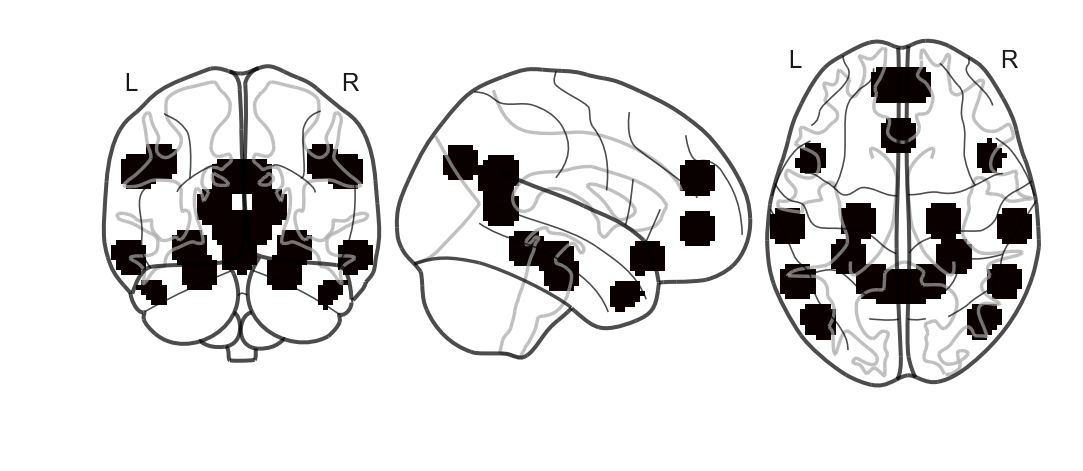

In [52]:
dmn_roi_img = nilearn.image.math_img(img1=roi_imgs[0], formula='img1 * 0')

for roi_img in roi_imgs:
    dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, img2=roi_img, formula='img1 + img2')
    
dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, formula='img1 > 0')
    
_ = nilearn.plotting.plot_glass_brain(dmn_roi_img)

In [55]:
results = {}

for subj in subj_list:
    for roi_img, roi_name in zip(roi_imgs, roi_names):

        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]

        results['pos', 'practiced', subj, roi_name] = cross_validation(X, target_pos)

        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]

        results['pos', 'unpracticed', subj, roi_name] = cross_validation(X, target_pos)

        print(subj, roi_name, end='\r')

In [56]:
with open('20200313_dmn_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [57]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_module', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name in roi_names:
        roi_module_name = roi_name.split('_')[0]
        re_roi_name = '_'.join(roi_name.split('_')[1:])
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj roi_module roi_name      Mapping  Mean Accuracy  Stage
0  GA01       Core  aMPFC_r  Unpracticed       0.312500  Early
1  GA01       Core  aMPFC_r  Unpracticed       0.319444   Late
2  GA01       Core  aMPFC_r    Practiced       0.319444  Early
3  GA01       Core  aMPFC_r    Practiced       0.305556   Late
4  GA01       Core  aMPFC_l  Unpracticed       0.364583  Early

In [66]:
wit_df.tail(20)

subj roi_module roi_name      Mapping  Mean Accuracy  Stage
2380  GA44     MTLsub     HF_l  Unpracticed       0.302083  Early
2381  GA44     MTLsub     HF_l  Unpracticed       0.295139   Late
2382  GA44     MTLsub     HF_l    Practiced       0.298611  Early
2383  GA44     MTLsub     HF_l    Practiced       0.284722   Late
2384  GA44     MTLsub    PHC_l  Unpracticed       0.340278  Early
2385  GA44     MTLsub    PHC_l  Unpracticed       0.298611   Late
2386  GA44     MTLsub    PHC_l    Practiced       0.246528  Early
2387  GA44     MTLsub    PHC_l    Practiced       0.256944   Late
2388  GA44     MTLsub   pIPL_l  Unpracticed       0.274306  Early
2389  GA44     MTLsub   pIPL_l  Unpracticed       0.291667   Late
2390  GA44     MTLsub   pIPL_l    Practiced       0.246528  Early
2391  GA44     MTLsub   pIPL_l    Practiced       0.288194   Late
2392  GA44     MTLsub   pIPL_r  Unpracticed       0.350694  Early
2393  GA44     MTLsub   pIPL_r  Unpracticed       0.326389   Late
2394  GA44     MTLsub   pIPL_r    Practiced       0.315972  Early
2395  GA44     MTLsub   pIPL_r    Practiced       0.312500   Late
2396  GA44     MTLsub     HF_r  Unpracticed       0.302083  Early
2397  GA44     MTLsub     HF_r  Unpracticed       0.322917   Late
2398  GA44     MTLsub     HF_r    Practiced       0.295139  Early
2399  GA44     MTLsub     HF_r    Practiced       0.347222   Late

In [82]:
pvals, tvals = [], []

for roi_module in ['Core', 'dMsub', 'MTLsub']:
    sub_df = wit_df[(wit_df['roi_module'] == roi_module) & (wit_df['Mapping'] == 'Practiced')]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, ['Core', 'dMsub', 'MTLsub'], pvals, tvals):
    print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                 Core False 0.14  1.73 0.093
                dMsub False 0.12  2.15 0.040
               MTLsub False 0.81 -0.24 0.811


In [84]:
pvals, tvals = [], []

for roi_name in roi_names:
    roi_module_name = roi_name.split('_')[0]
    re_roi_name = '_'.join(roi_name.split('_')[1:])
    
    sub_df = wit_df[(wit_df['roi_name'] == re_roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

   dMsub_TempP_r_temp  True 0.00  4.24 0.000


In [81]:
pvals, tvals = [], []

for roi_module in ['Core', 'dMsub', 'MTLsub']:
    sub_df = wit_df[(wit_df['roi_module'] == roi_module) & (wit_df['Stage'] == 'Late')]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, ['Core', 'dMsub', 'MTLsub'], pvals, tvals):
    print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                 Core False 0.19 -1.91 0.067
                dMsub False 0.19 -1.58 0.124
               MTLsub False 0.51 -0.67 0.506


In [85]:
pvals, tvals = [], []

for roi_name in roi_names:
    roi_module_name = roi_name.split('_')[0]
    re_roi_name = '_'.join(roi_name.split('_')[1:])
    
    sub_df = wit_df[(wit_df['roi_name'] == re_roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

In [74]:
def draw_avg_lineplot(roi_module, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_module'] == roi_module]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.3)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

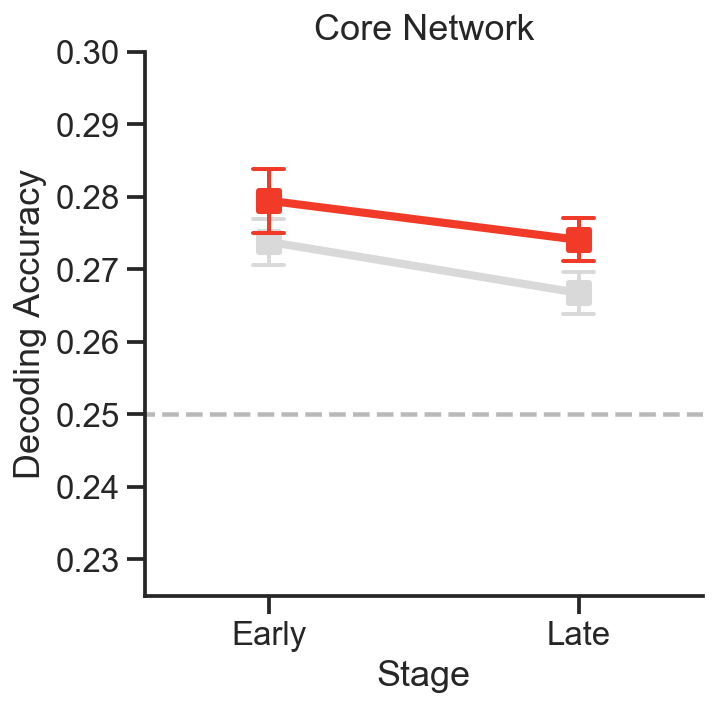

In [75]:
draw_avg_lineplot('Core', 'Core Network')

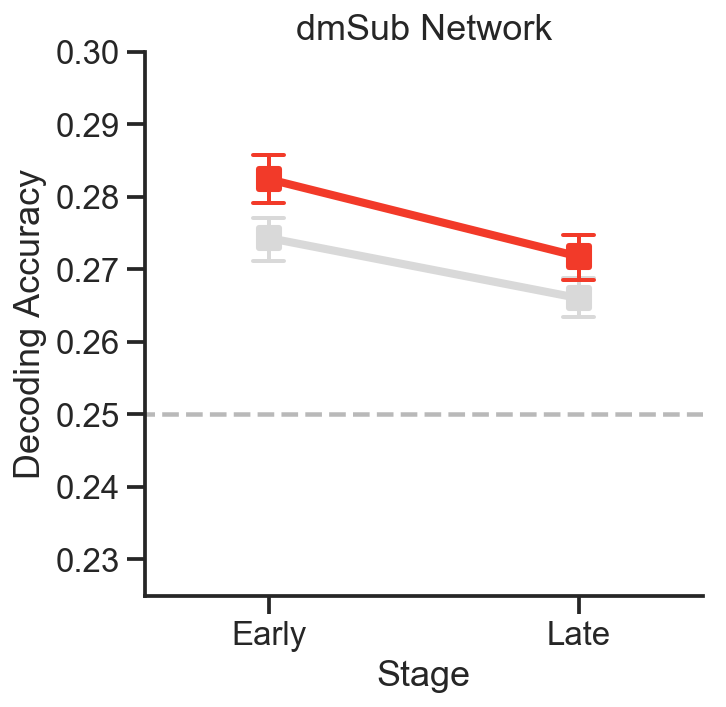

In [76]:
draw_avg_lineplot('dMsub', 'dmSub Network')

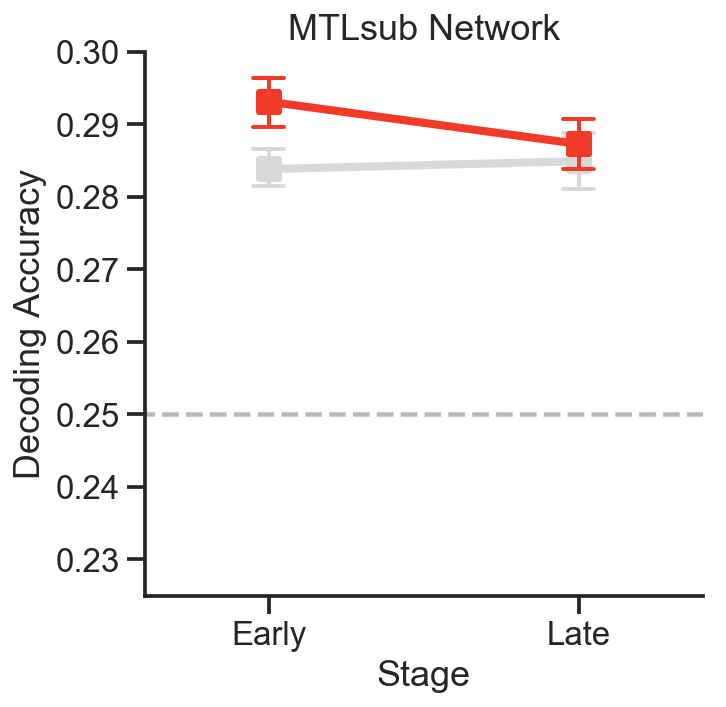

In [77]:
draw_avg_lineplot('MTLsub', 'MTLsub Network')

# Visual areas

In [7]:
with open('20190715_p-and-unp_e-and-l_Fan.pkl', 'rb') as file:
    wit_results = pickle.load(file=file)

In [9]:
roi_info = pd.read_csv('/Volumes/clmnlab/GA/fmri_data/masks/Fan/20190926/fan_cluster_net_20191010.csv')
roi_info.head()

Unnamed: 0  label     region subregion_name             name  \
0           0      1  SFG_L_7_1            A8m   SFG_L_7_1 (8m)   
1           1      2  SFG_R_7_1            A8m   SFG_R_7_1 (8m)   
2           2      3  SFG_L_7_2           A8dl  SFG_L_7_2 (8dl)   
3           3      4  SFG_R_7_2           A8dl  SFG_R_7_2 (8dl)   
4           4      5  SFG_L_7_3            A9l   SFG_L_7_3 (9l)   

                                        full_name           lobe  \
0        Lt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
1        Rt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
2  Lt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
3  Rt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
4       Lt. superior frontal gyrus (BA9, lateral)  Frontal Lobe    

                           gyrus               descriptions mni_coordinate  \
0  SFG, Superior Frontal Gyrus           A8m, medial area 8    -5 ,15, 54    
1  SFG, Superior Frontal Gyrus           A8m, medial area 8     7, 16, 54    
2  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8   -18, 24, 53    
3  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8    22, 26, 51    
4  SFG, Superior Frontal Gyrus          A9l, lateral area 9   -11, 49, 40    

  laterality  yeo_7network  yeo_17network yeo_network_name  
0       left             6             17   Frontoparietal  
1      right             4              8       vAttention  
2       left             7             16          Default  
3      right             6             13   Frontoparietal  
4       left             7             17          Default

In [32]:
roi_imgs = {}
roi_names = []
roi_indices = []
roi_network = []

for _, row in roi_info.iterrows():
    if row['yeo_17network'] == 1:
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append(row['full_name'])
        roi_indices.append(row['label'])
        roi_network.append(row['yeo_17network'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [33]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, roi_index in zip(roi_names, roi_indices):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)

In [34]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

Lt. lingual gyrus (caudal)  True 0.04 -2.94 0.006
Rt. lingual gyrus (caudal)  True 0.04 -2.76 0.010
Lt. cuneus gyrus (caudal)  True 0.04 -2.84 0.008
Rt. cuneus gyrus (caudal)  True 0.04 -2.65 0.013
Rt. lingual gyrus (rostral) False 0.09 -2.15 0.040
Rt. occipital polar cortex False 0.09 -2.09 0.046
Lt. inferior occipital gyrus False 0.06 -2.46 0.020
Rt. inferior occipital gyrus False 0.09 -2.06 0.049


In [35]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

Lt. cuneus gyrus (caudal) False 0.14  2.37 0.025
Lt. occipital polar cortex False 0.14  2.26 0.031


In [31]:
img = nilearn.image.math_img(img1=roi_imgs['FuG_L_3_2'], formula='img1 * 0')

for _, row in roi_info.iterrows():
    roi_img = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
    net_idx = row['yeo_17network']
    if net_idx == 0:
        net_idx = 18
    img = nilearn.image.math_img(img1=img, img2=roi_img, formula='img1 + img2 * %d' % (net_idx))
    
img.to_filename('Yeo_et_al_network17.nii.gz')

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [36]:
roi_imgs

{'FuG_L_3_2': <nibabel.nifti1.Nifti1Image at 0x12d50a160>,
 'FuG_R_3_2': <nibabel.nifti1.Nifti1Image at 0x12d22e048>,
 'MVOcC_L_5_1': <nibabel.nifti1.Nifti1Image at 0x12d22e5c0>,
 'MVOcC_R_5_1': <nibabel.nifti1.Nifti1Image at 0x12d22e860>,
 'MVOcC_L_5_3': <nibabel.nifti1.Nifti1Image at 0x12d22e5f8>,
 'MVOcC_R_5_3': <nibabel.nifti1.Nifti1Image at 0x12d22efd0>,
 'MVOcC_R_5_4': <nibabel.nifti1.Nifti1Image at 0x12d22ea58>,
 'LOcC_L_4_1': <nibabel.nifti1.Nifti1Image at 0x12d22ec88>,
 'LOcC_R_4_1': <nibabel.nifti1.Nifti1Image at 0x12d22ecf8>,
 'LOcC_L_4_3': <nibabel.nifti1.Nifti1Image at 0x12d22e358>,
 'LOcC_R_4_3': <nibabel.nifti1.Nifti1Image at 0x12d738048>,
 'LOcC_L_4_4': <nibabel.nifti1.Nifti1Image at 0x12d738be0>,
 'LOcC_R_4_4': <nibabel.nifti1.Nifti1Image at 0x12d738b38>,
 'LOcC_L_2_2': <nibabel.nifti1.Nifti1Image at 0x12d738d68>}

In [35]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA', '#C5C7D2']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.8)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

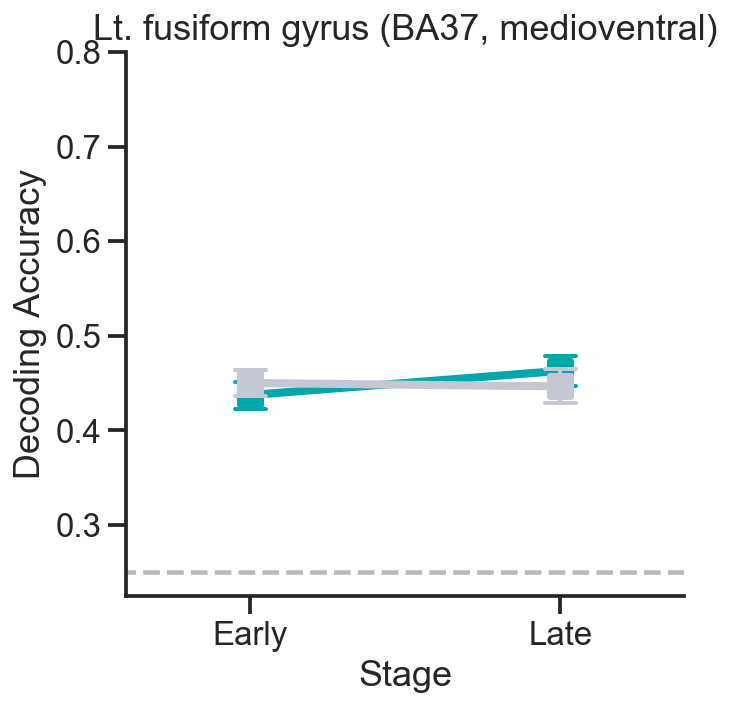

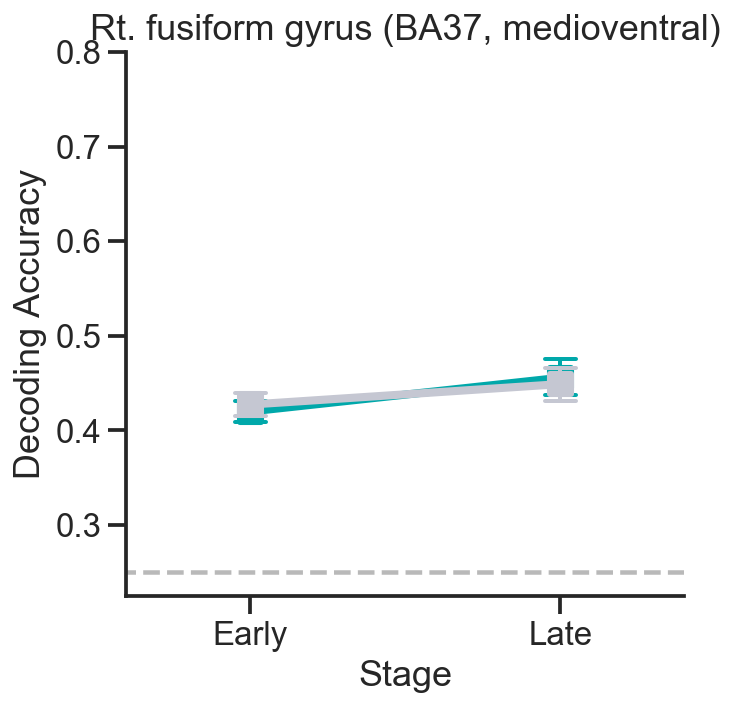

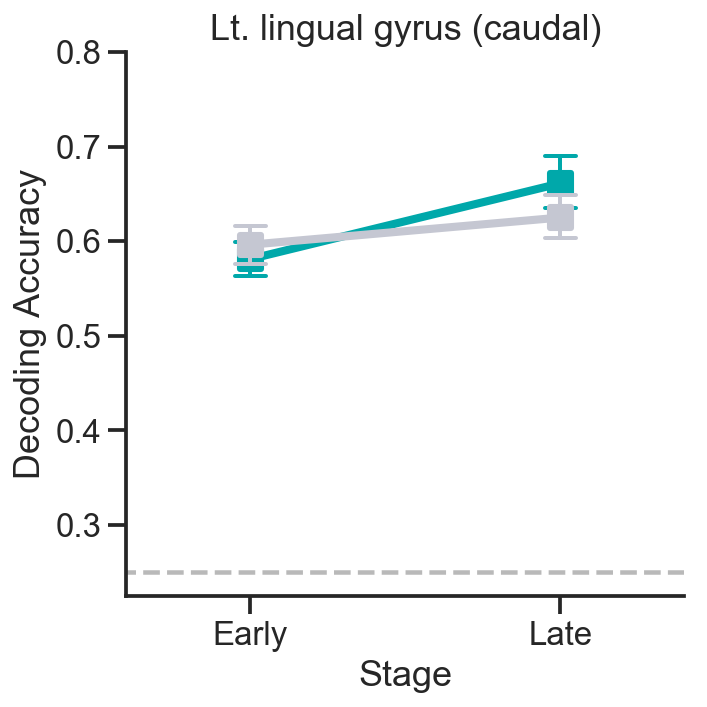

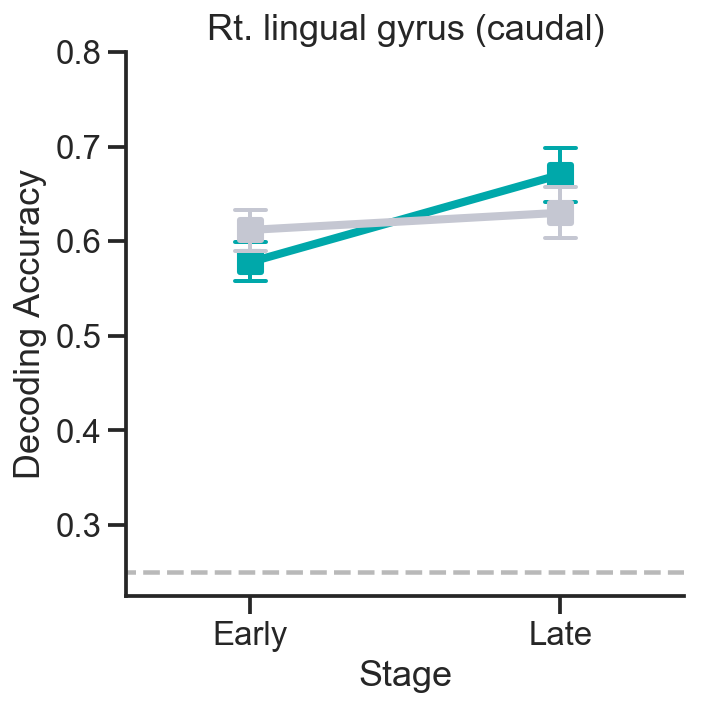

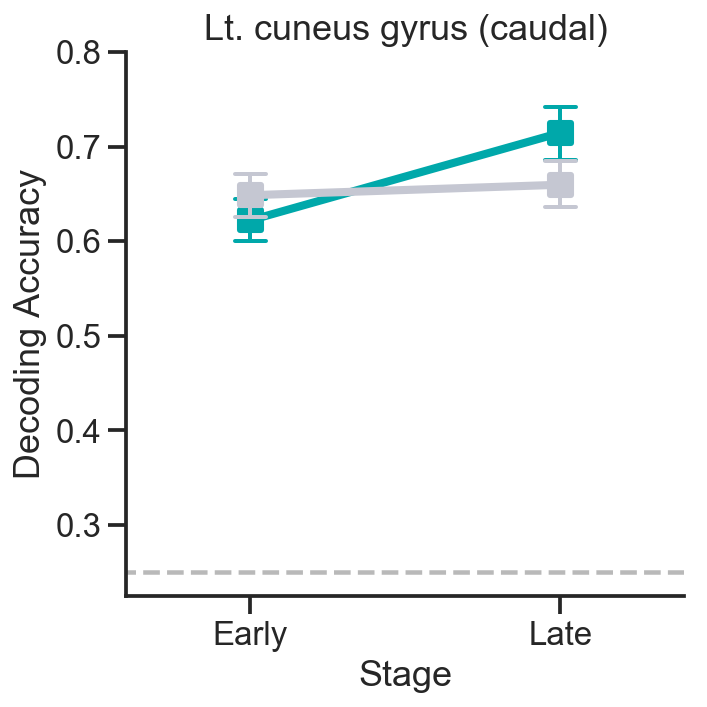

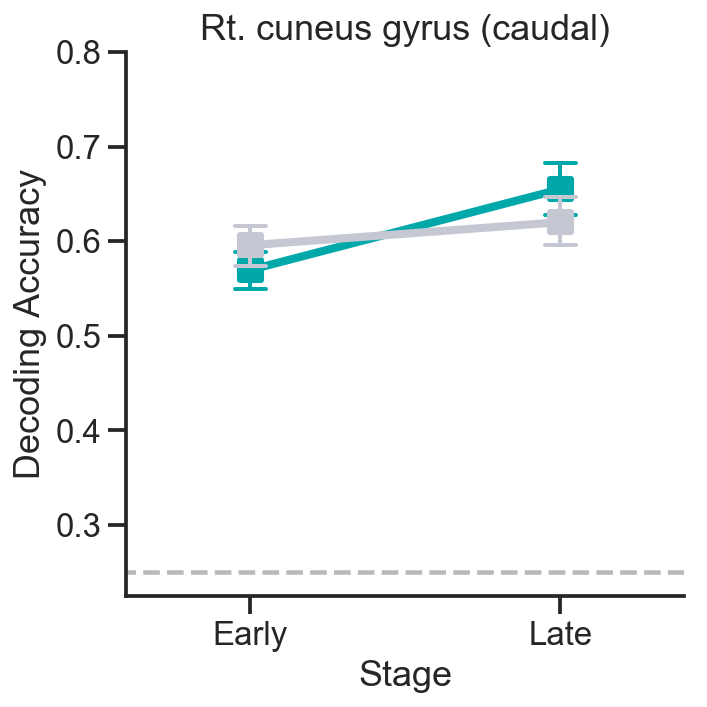

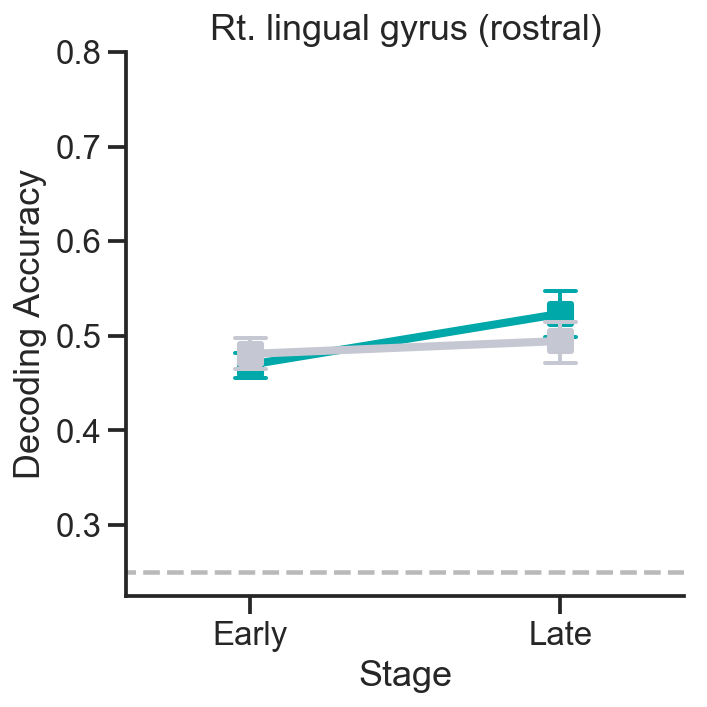

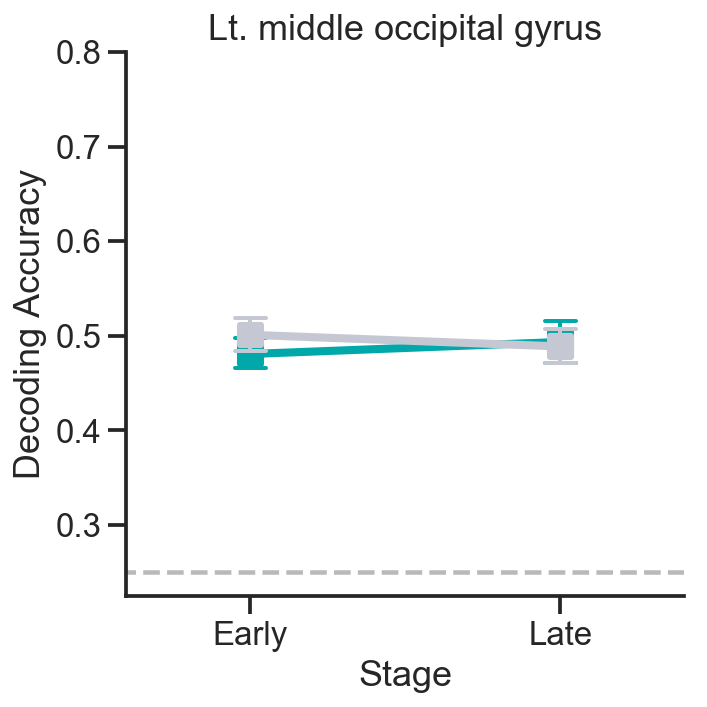

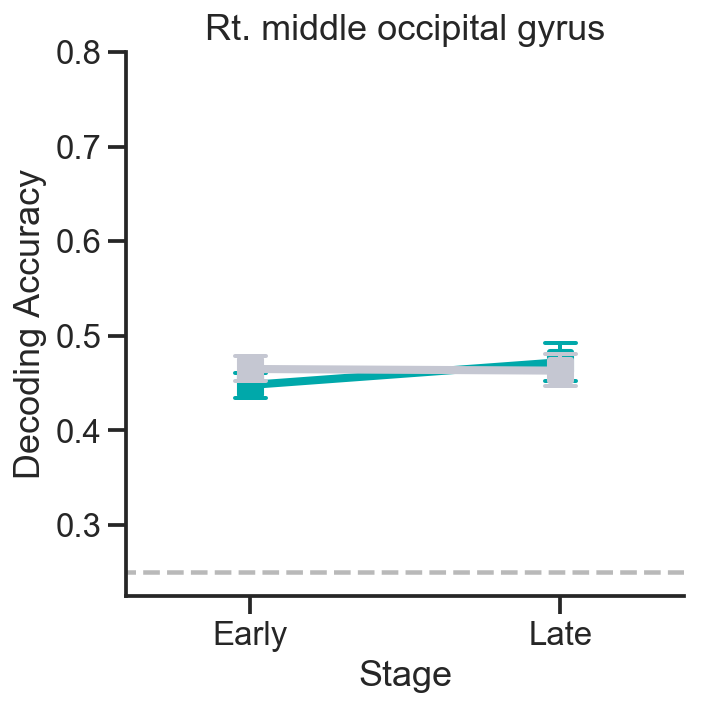

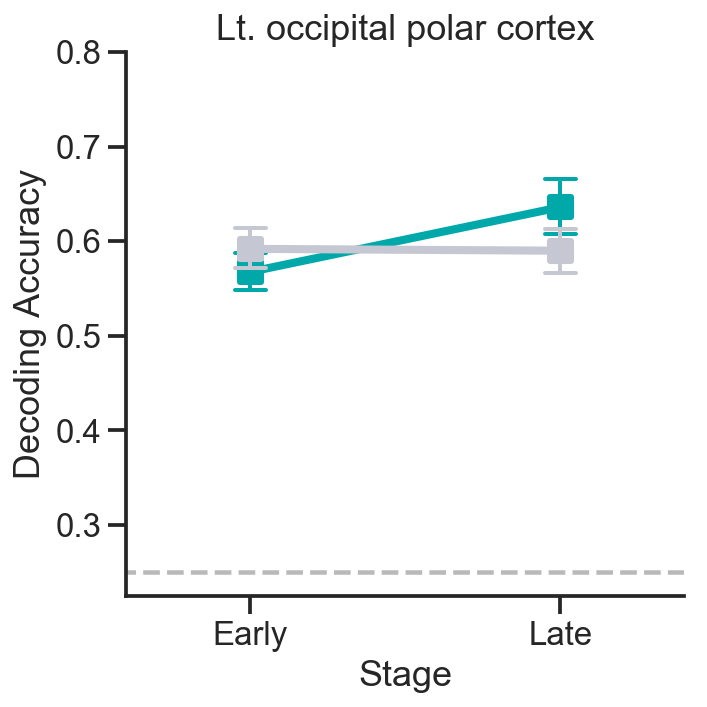

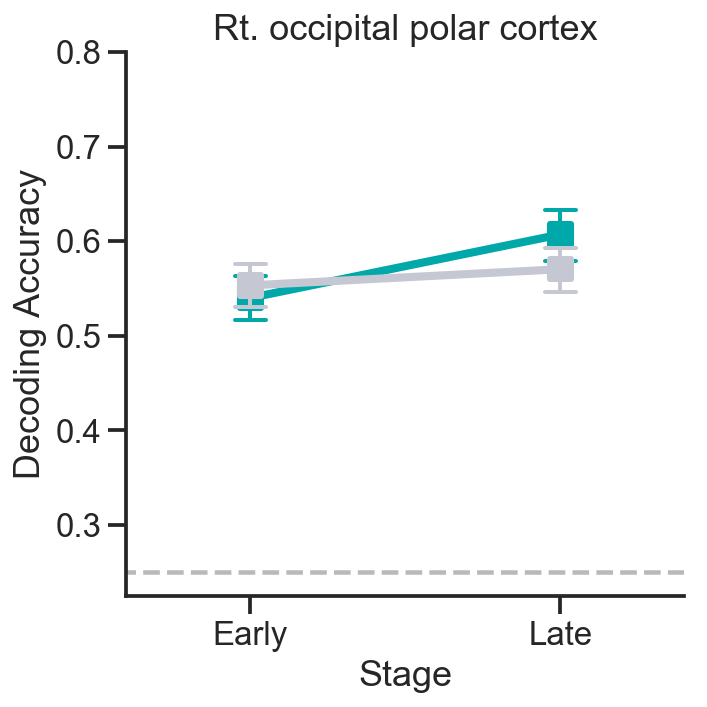

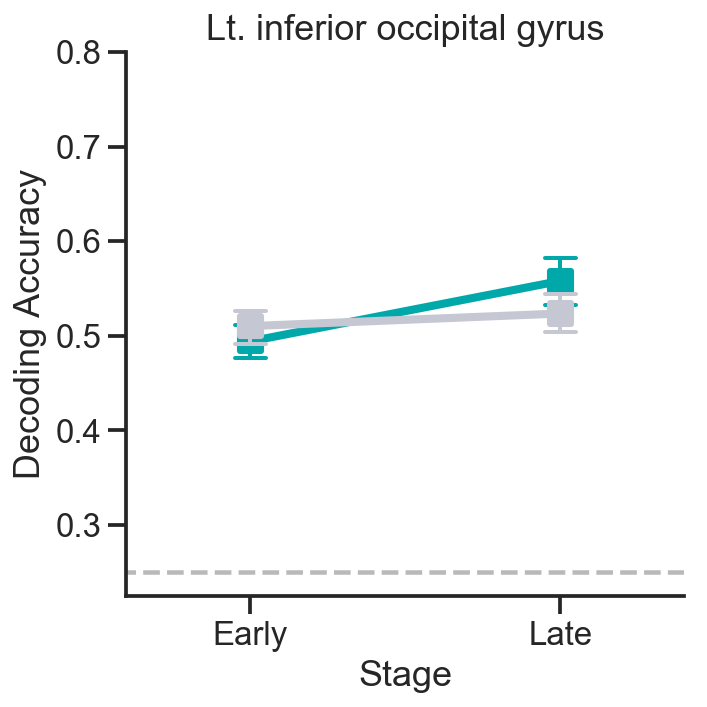

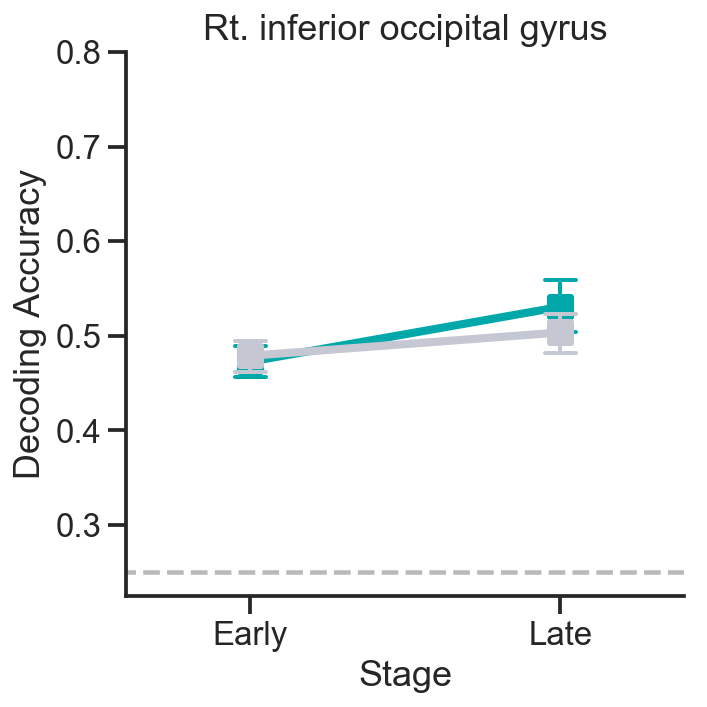

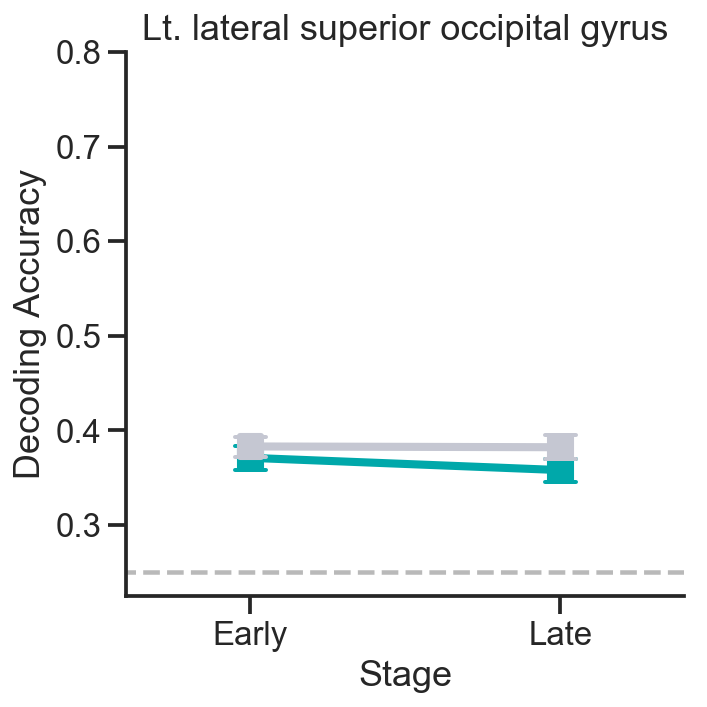

In [42]:
for name, n in zip(roi_names, roi_network):
    draw_lineplot(name, name)

In [36]:
sns.set(style="whitegrid")

def draw_avg_lineplot(roi_indices, name):
    plt.figure(figsize=(5, 5))

    sub_df = wit_df[wit_df['roi_name'].isin(roi_names)].groupby(['subj', 'Mapping', 'Stage']).mean().reset_index()
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    sns.despine(left=True)
    
    #aov = pg.rm_anova2(subject='subj', dv='mean_acc', within=['stage', 'practiced'], data=sub_df)
    #plt.title(name + '\nstage * mapping corr p = %.3f' % (aov['p-GG-corr'][1]))
    
    t, p = scipy.stats.ttest_rel(sub_df[(sub_df['Mapping'] == 'Practiced') & (sub_df['Stage'] == 'Early')]['Mean Accuracy'],
                                 sub_df[(sub_df['Mapping'] == 'Practiced') & (sub_df['Stage'] == 'Late')]['Mean Accuracy'])
    
    plt.title(name + '\nearly vs. late (practiced) p = %.3f' % (p))

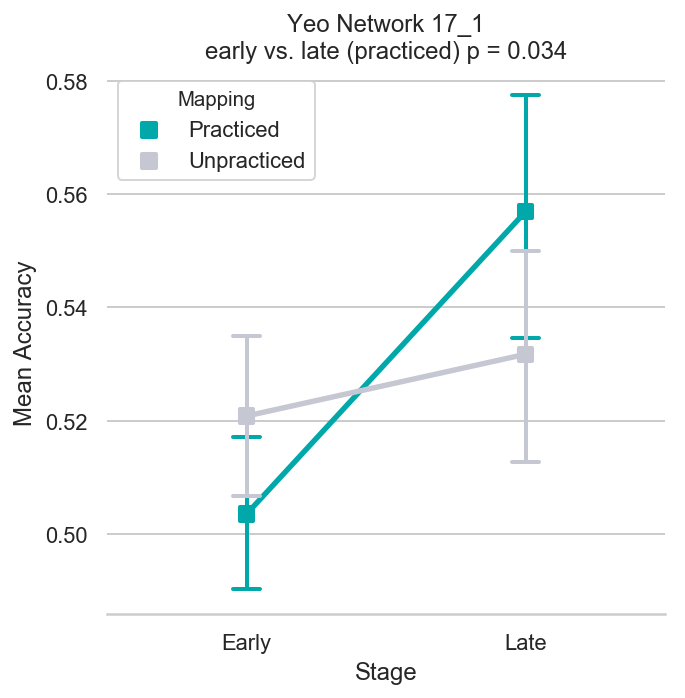

In [65]:
draw_avg_lineplot(roi_names, 'Yeo Network 17_1')

In [63]:
wit_df[wit_df['roi_name'].isin(roi_names)].groupby(['subj', 'Mapping', 'Stage']).mean().reset_index()

subj      Mapping  Stage  Mean Accuracy
0    GA01    Practiced  Early       0.588542
1    GA01    Practiced   Late       0.422371
2    GA01  Unpracticed  Early       0.474206
3    GA01  Unpracticed   Late       0.596726
4    GA02    Practiced  Early       0.504216
..    ...          ...    ...            ...
115  GA42  Unpracticed   Late       0.290675
116  GA44    Practiced  Early       0.474702
117  GA44    Practiced   Late       0.665923
118  GA44  Unpracticed  Early       0.552083
119  GA44  Unpracticed   Late       0.562500

[120 rows x 4 columns]

In [66]:
roi_imgs = {}
roi_names = []
roi_indices = []
roi_network = []

for _, row in roi_info.iterrows():
    if row['yeo_17network'] == 2:
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append(row['full_name'])
        roi_indices.append(row['label'])
        roi_network.append(row['yeo_17network'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [67]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, roi_index in zip(roi_names, roi_indices):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)

In [68]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

Lt. cuneus gyrus (rostral)  True 0.03 -2.94 0.006
Rt. cuneus gyrus (rostral)  True 0.03 -3.32 0.002
Rt. parietooccipital sulcus (ventromedial)  True 0.04 -2.75 0.010


In [69]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

Lt. cuneus gyrus (rostral) False 0.05  2.76 0.010
Rt. cuneus gyrus (rostral) False 0.09  2.38 0.024
Rt. parietooccipital sulcus (ventromedial)  True 0.03  3.23 0.003


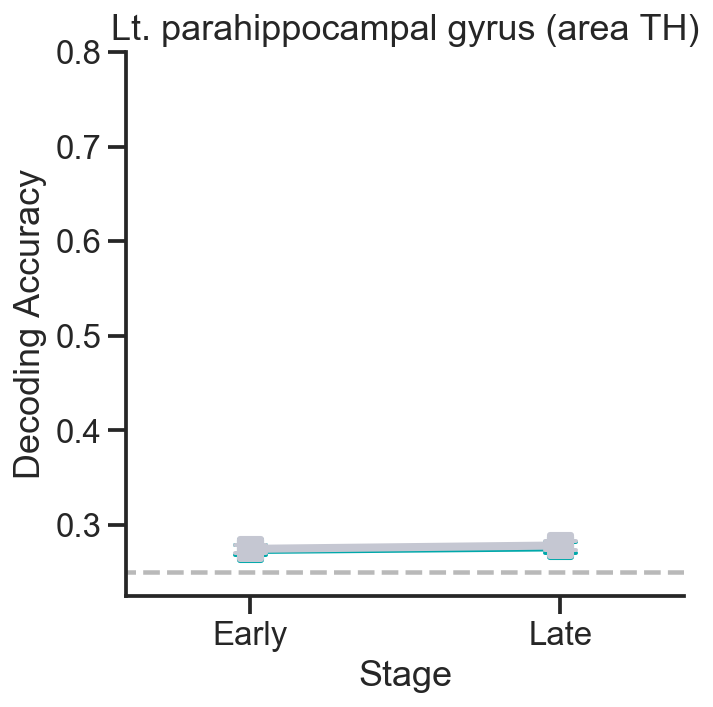

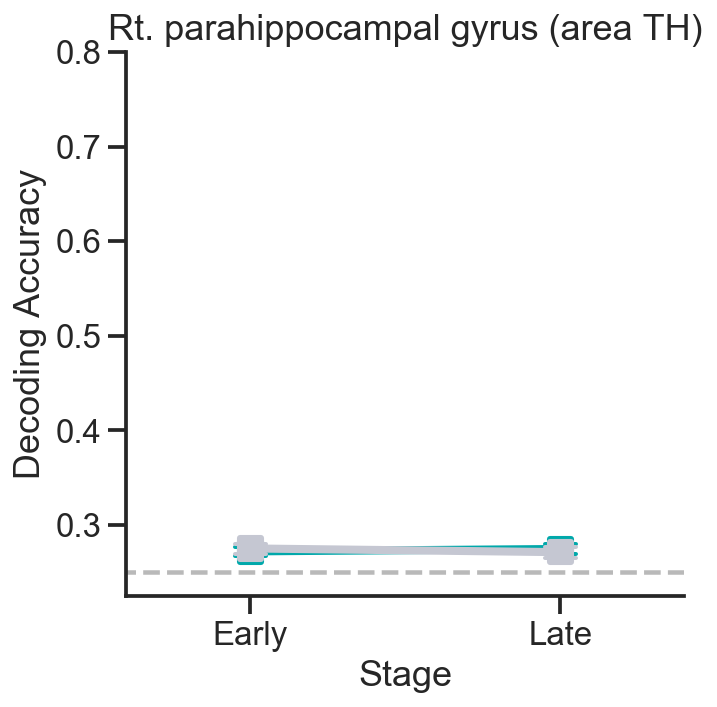

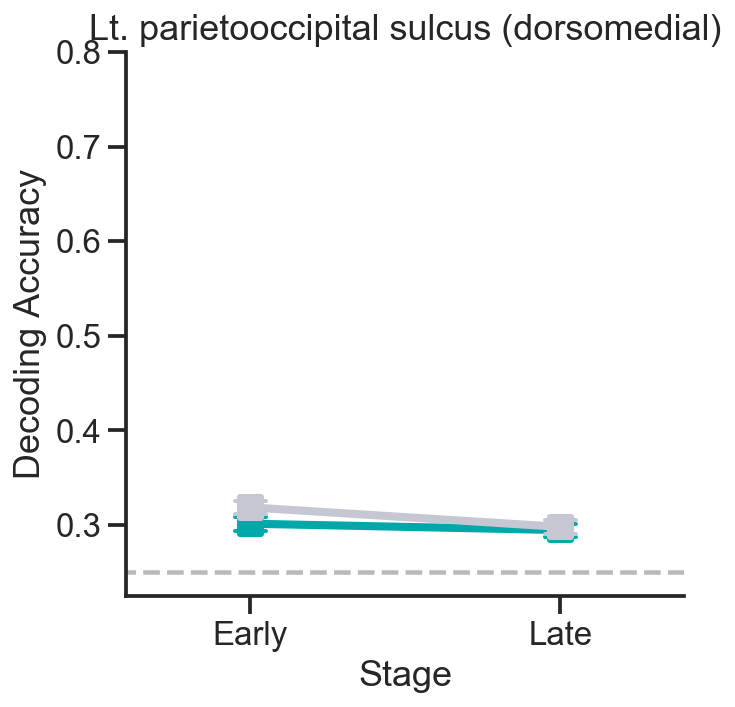

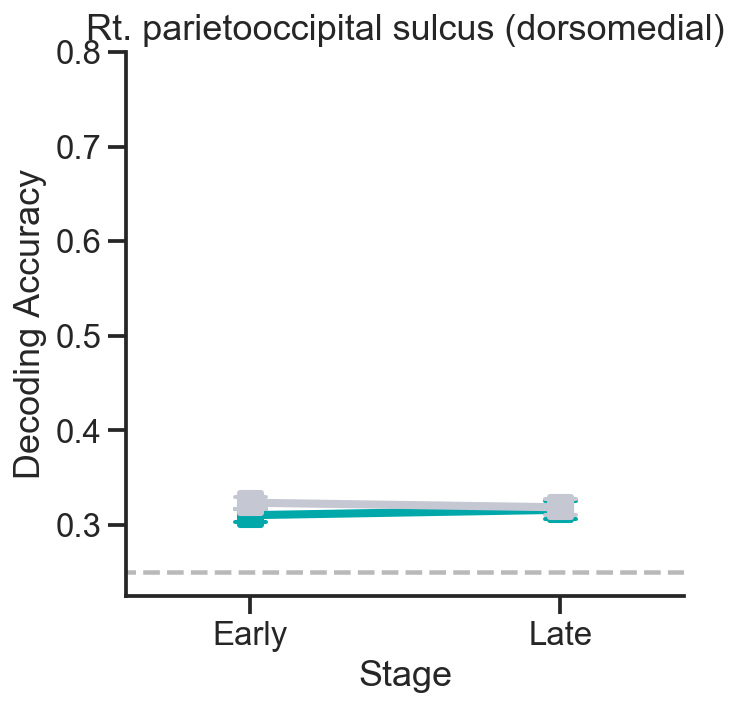

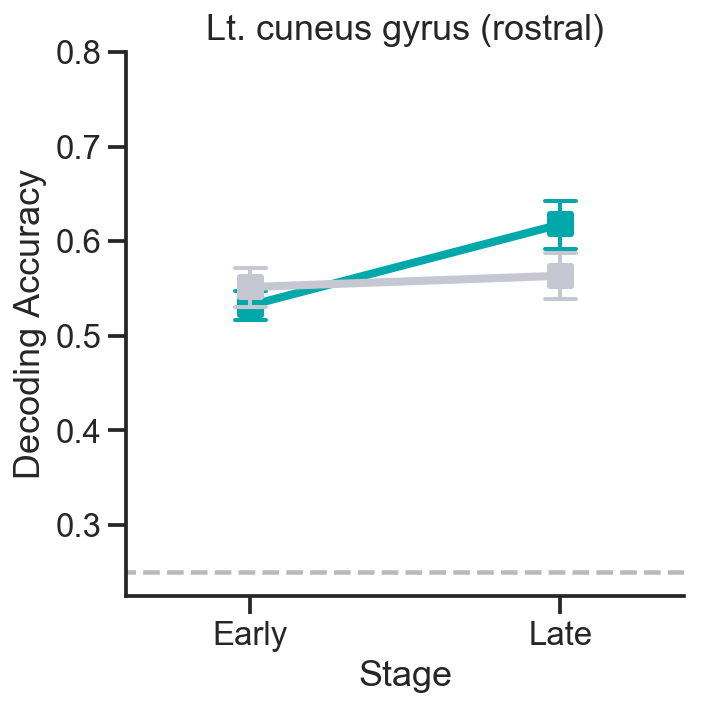

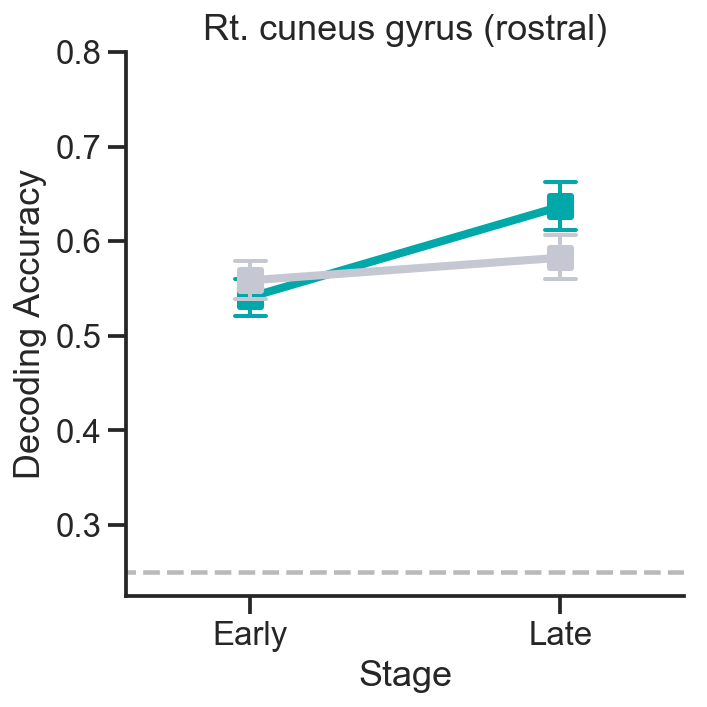

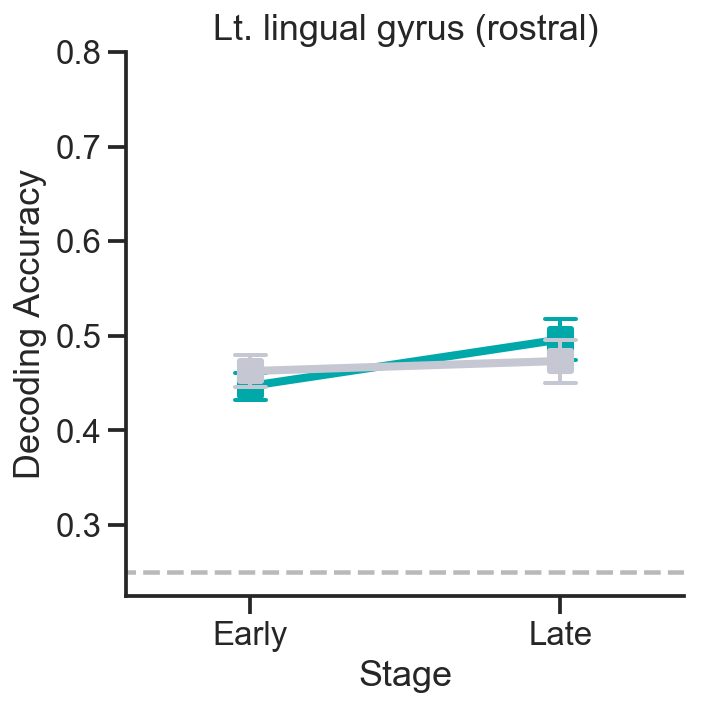

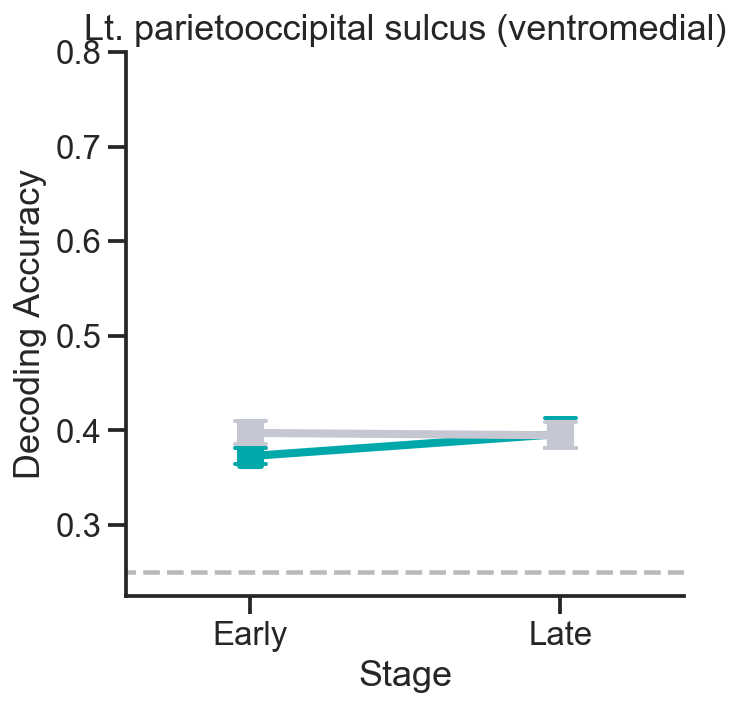

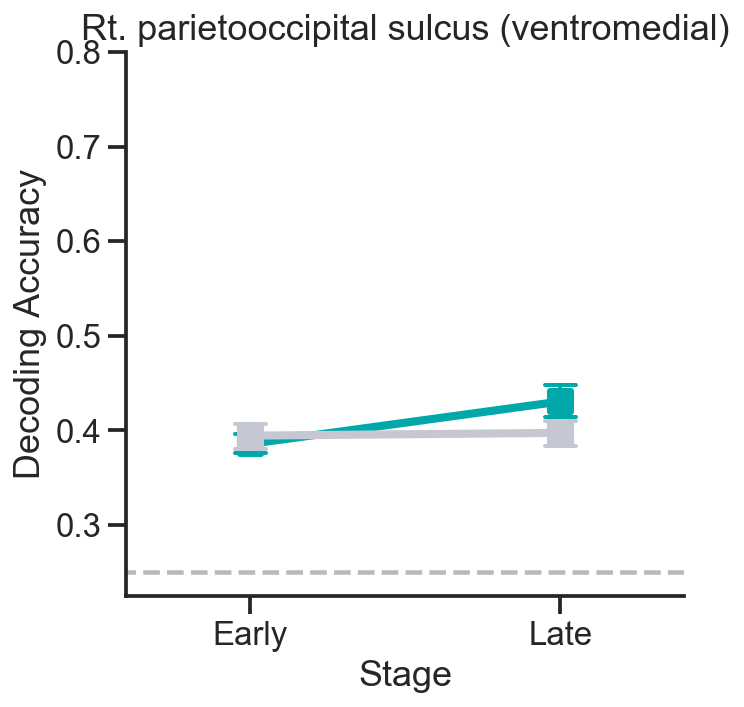

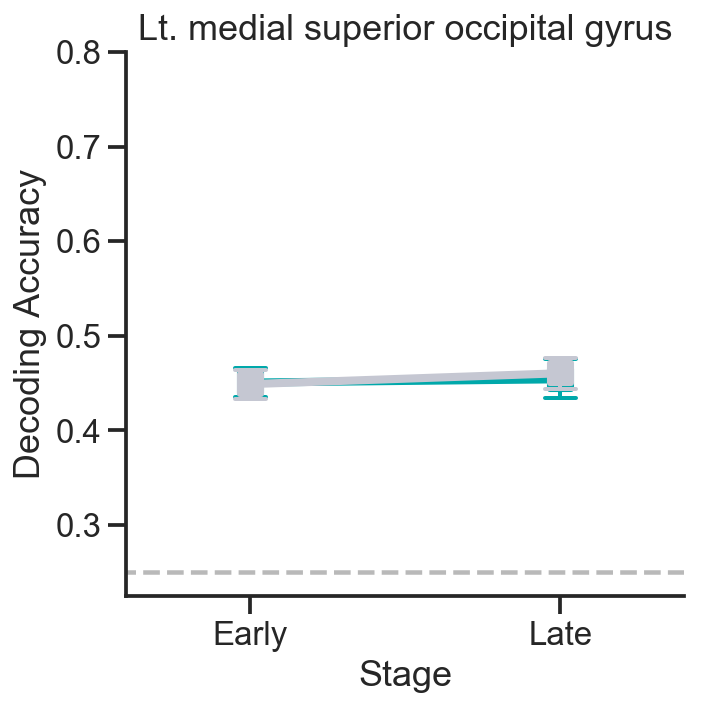

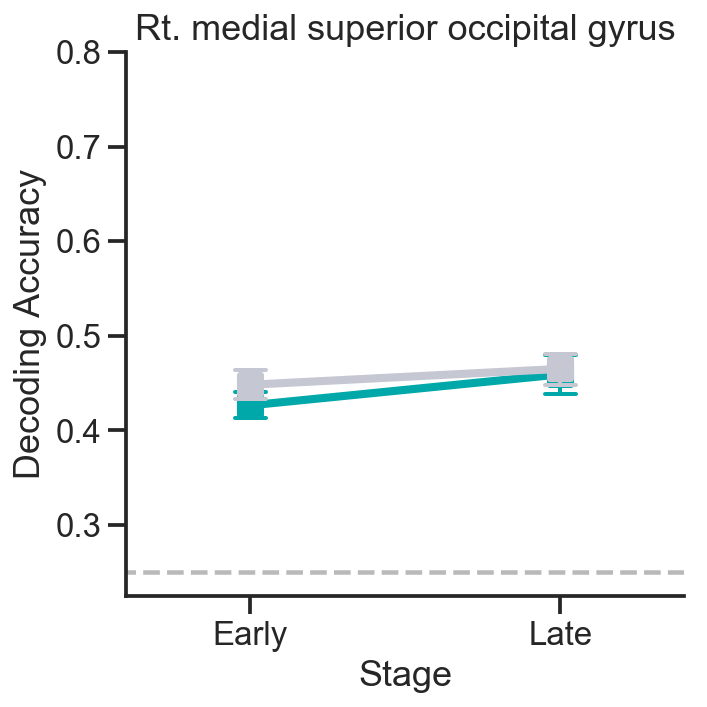

In [71]:
for name, n in zip(roi_names, roi_network):
    draw_lineplot(name, name)

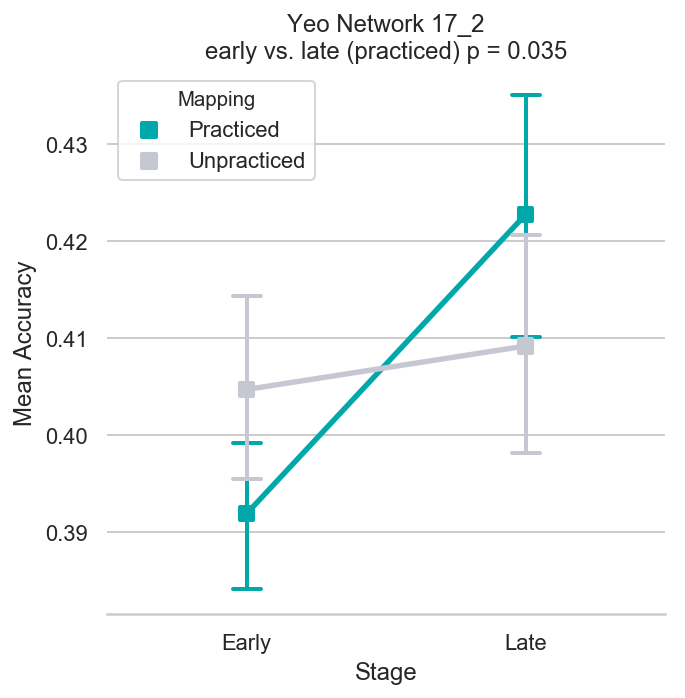

In [75]:
draw_avg_lineplot(roi_names, 'Yeo Network 17_2')

In [77]:
roi_imgs = {}
roi_names = []
roi_indices = []
roi_network = []

for _, row in roi_info.iterrows():
    if row['yeo_17network'] in set([1, 2]):
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append(row['full_name'])
        roi_indices.append(row['label'])
        roi_network.append(row['yeo_17network'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [78]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, roi_index in zip(roi_names, roi_indices):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj                                 roi_name      Mapping  Mean Accuracy  \
0  GA01  Lt. fusiform gyrus (BA37, medioventral)    Practiced       0.493056   
1  GA01  Lt. fusiform gyrus (BA37, medioventral)    Practiced       0.375000   
2  GA01  Lt. fusiform gyrus (BA37, medioventral)  Unpracticed       0.406250   
3  GA01  Lt. fusiform gyrus (BA37, medioventral)  Unpracticed       0.430556   
4  GA01  Rt. fusiform gyrus (BA37, medioventral)    Practiced       0.489583   

   Stage  
0  Early  
1   Late  
2  Early  
3   Late  
4  Early

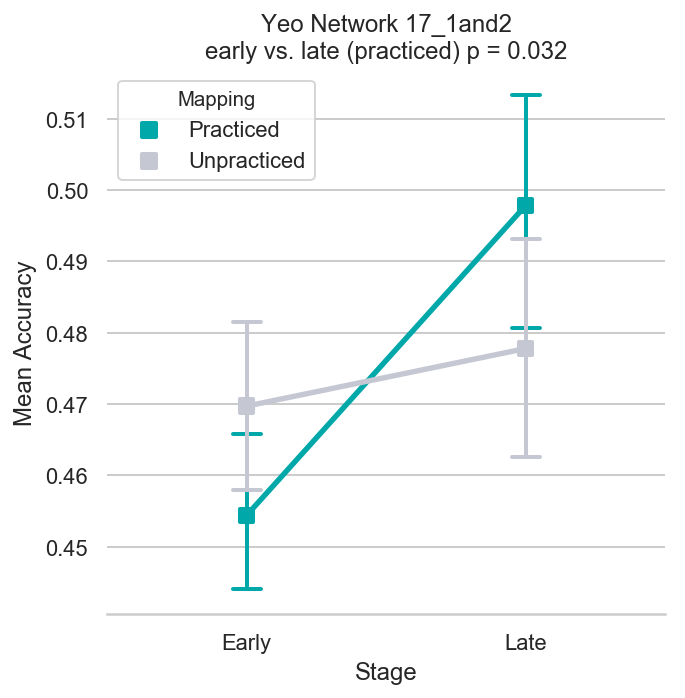

In [80]:
draw_avg_lineplot(roi_names, 'Yeo Network 17_1and2')

In [81]:
roi_imgs = {}
roi_names = []
roi_indices = []
roi_network = []

for _, row in roi_info.iterrows():
    if row['yeo_network_name'] == 'visual (occipital)':
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append(row['full_name'])
        roi_indices.append(row['label'])
        roi_network.append(row['yeo_17network'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [82]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, roi_index in zip(roi_names, roi_indices):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_index]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_index]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj                                 roi_name      Mapping  Mean Accuracy  \
0  GA01  Lt. fusiform gyrus (BA37, medioventral)    Practiced       0.493056   
1  GA01  Lt. fusiform gyrus (BA37, medioventral)    Practiced       0.375000   
2  GA01  Lt. fusiform gyrus (BA37, medioventral)  Unpracticed       0.406250   
3  GA01  Lt. fusiform gyrus (BA37, medioventral)  Unpracticed       0.430556   
4  GA01  Rt. fusiform gyrus (BA37, medioventral)    Practiced       0.489583   

   Stage  
0  Early  
1   Late  
2  Early  
3   Late  
4  Early

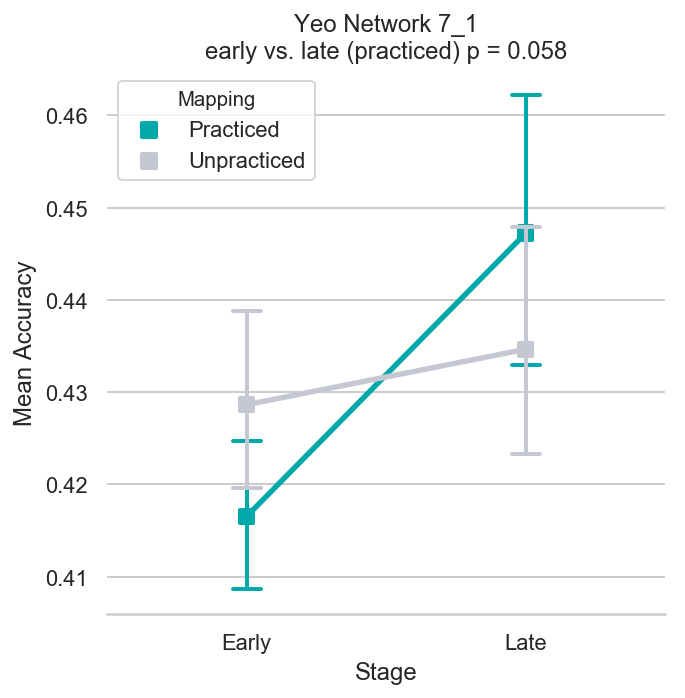

In [84]:
draw_avg_lineplot(roi_names, 'Yeo Network 7_1')

# Visual area, not averaged... as a whole ROI

In [10]:
roi_info = pd.read_csv('/Volumes/clmnlab/GA/fmri_data/masks/Fan/20190926/fan_cluster_net_20191010.csv')
roi_info.head()

Unnamed: 0  label     region subregion_name             name  \
0           0      1  SFG_L_7_1            A8m   SFG_L_7_1 (8m)   
1           1      2  SFG_R_7_1            A8m   SFG_R_7_1 (8m)   
2           2      3  SFG_L_7_2           A8dl  SFG_L_7_2 (8dl)   
3           3      4  SFG_R_7_2           A8dl  SFG_R_7_2 (8dl)   
4           4      5  SFG_L_7_3            A9l   SFG_L_7_3 (9l)   

                                        full_name           lobe  \
0        Lt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
1        Rt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
2  Lt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
3  Rt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
4       Lt. superior frontal gyrus (BA9, lateral)  Frontal Lobe    

                           gyrus               descriptions mni_coordinate  \
0  SFG, Superior Frontal Gyrus           A8m, medial area 8    -5 ,15, 54    
1  SFG, Superior Frontal Gyrus           A8m, medial area 8     7, 16, 54    
2  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8   -18, 24, 53    
3  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8    22, 26, 51    
4  SFG, Superior Frontal Gyrus          A9l, lateral area 9   -11, 49, 40    

  laterality  yeo_7network  yeo_17network yeo_network_name  
0       left             6             17   Frontoparietal  
1      right             4              8       vAttention  
2       left             7             16          Default  
3      right             6             13   Frontoparietal  
4       left             7             17          Default

In [12]:
mt_roi_names = ['LOcC_L_4_2', 'LOcC_R_4_2']

In [19]:
roi_imgs = {}
roi_regions = []
roi_names = []
roi_indices = []
roi_network = []

for _, row in roi_info.iterrows():
    if row['yeo_17network'] in set([1, 2]) or row['region'] in mt_roi_names:
        roi_imgs[row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_regions.append(row['region'])
        roi_names.append(row['full_name'])
        roi_indices.append(row['label'])
        roi_network.append(row['yeo_17network'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [20]:
vis1_rois = []
vis2_rois = []
mt_rois = []

for idx, clust_idx, region in zip(roi_indices, roi_network, roi_regions):
    if region in mt_roi_names:
        mt_rois.append(region)
    elif clust_idx == 1:
        vis1_rois.append(region)
    elif clust_idx == 2:
        vis2_rois.append(region)
    else:
        raise ValueError()

In [21]:
len(mt_rois), len(vis1_rois), len(vis2_rois)

(2, 14, 11)

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


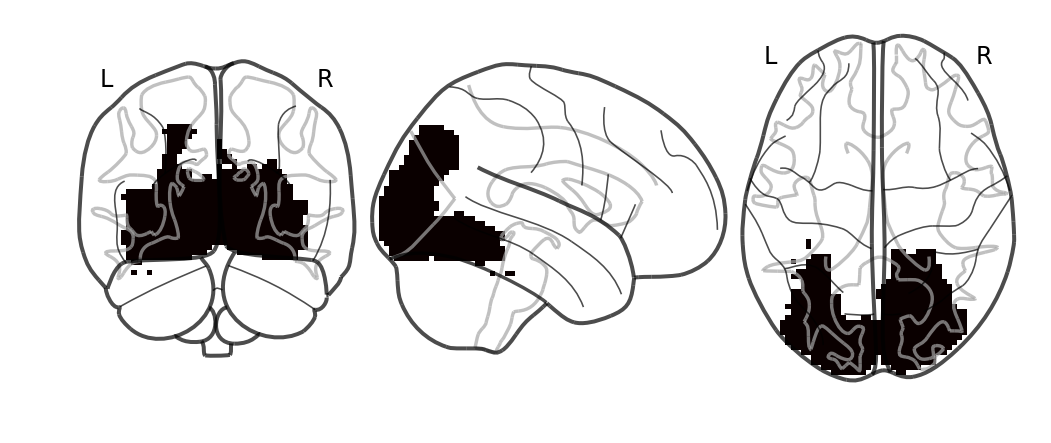

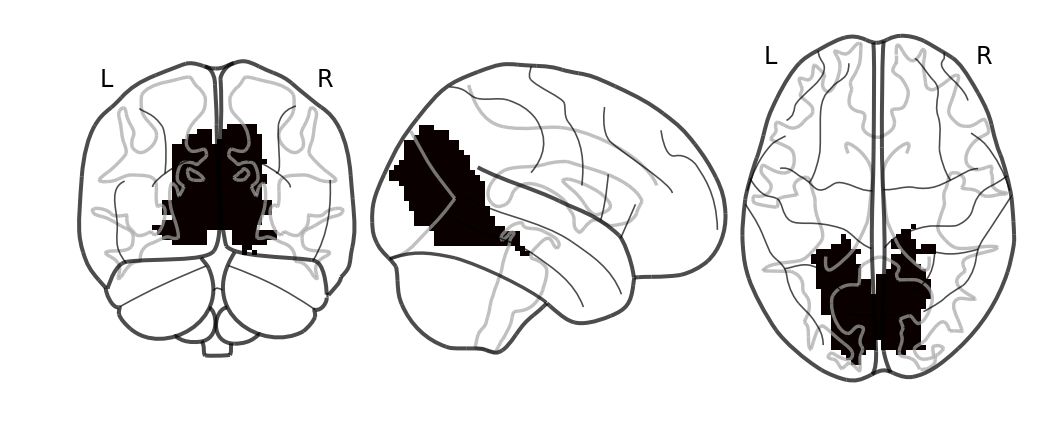

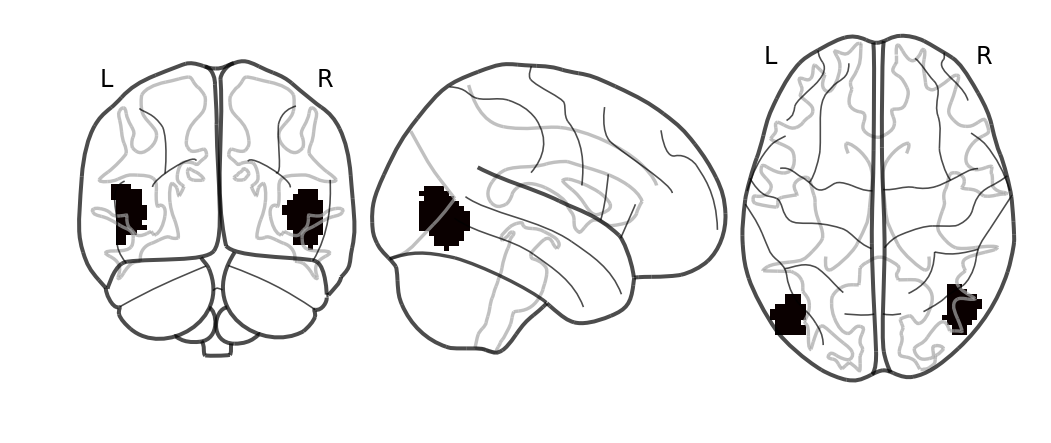

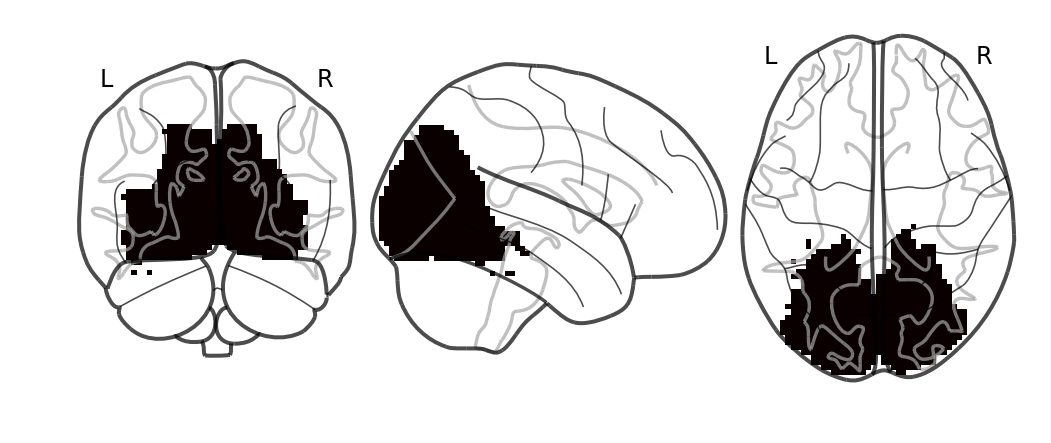

In [25]:
vis1_roi_img = nilearn.image.math_img(img1=roi_imgs['FuG_L_3_2'], formula='img1 * 0')
vis2_roi_img = nilearn.image.math_img(img1=roi_imgs['FuG_L_3_2'], formula='img1 * 0')
mt_roi_img = nilearn.image.math_img(img1=roi_imgs['FuG_L_3_2'], formula='img1 * 0')

for region in vis1_rois:
    vis1_roi_img = nilearn.image.math_img(img1=vis1_roi_img, img2=roi_imgs[region], formula='img1 + img2')
    
for region in vis2_rois:
    vis2_roi_img = nilearn.image.math_img(img1=vis2_roi_img, img2=roi_imgs[region], formula='img1 + img2')
    
for region in mt_rois:
    mt_roi_img = nilearn.image.math_img(img1=mt_roi_img, img2=roi_imgs[region], formula='img1 + img2')
    
vis_roi_img = nilearn.image.math_img(img1=vis1_roi_img, img2=vis2_roi_img, formula='img1 + img2')
    
_ = nilearn.plotting.plot_glass_brain(vis1_roi_img)
_ = nilearn.plotting.plot_glass_brain(vis2_roi_img)
_ = nilearn.plotting.plot_glass_brain(mt_roi_img)
_ = nilearn.plotting.plot_glass_brain(vis_roi_img)

In [27]:
vis_roi_img_list = [('yeo_network17_1', vis1_roi_img),
                    ('yeo_network17_2', vis2_roi_img),
                    ('yeo_network17_1+2', vis_roi_img),
                    ('v5/mt+', mt_roi_img)]

In [28]:
results = {}

for subj in subj_list:
    for name, roi_img in vis_roi_img_list:
        if ('pos', 'unpracticed', subj, name) in results:
            continue
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]
        
        results['pos', 'practiced', subj, name] = cross_validation(X, target_pos)
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]
        
        results['pos', 'unpracticed', subj, name] = cross_validation(X, target_pos)
        
        print(subj, name, end='\r')

In [31]:
for subj in subj_list:
    for name, roi_img in vis_roi_img_list[-1:]:
        if ('path', 'unpracticed', subj, name) in results:
            continue
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]
        
        results['path', 'practiced', subj, name] = cross_validation(X, target_path)
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]
        
        results['path', 'unpracticed', subj, name] = cross_validation(X, target_path)
        
        print(subj, name, end='\r')

In [32]:
with open('20191203_vis-area_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [70]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, _ in vis_roi_img_list:
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj         roi_name      Mapping  Mean Accuracy  Stage
0  GA01  yeo_network17_1    Practiced       0.819444  Early
1  GA01  yeo_network17_1    Practiced       0.559028   Late
2  GA01  yeo_network17_1  Unpracticed       0.649306  Early
3  GA01  yeo_network17_1  Unpracticed       0.791667   Late
4  GA01  yeo_network17_2    Practiced       0.704861  Early

In [81]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA', '#C5C7D2', '#00A8AA', '#C5C7D2']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', style='roi_name', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    #plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    #plt.ylim(0.225, 0.9)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

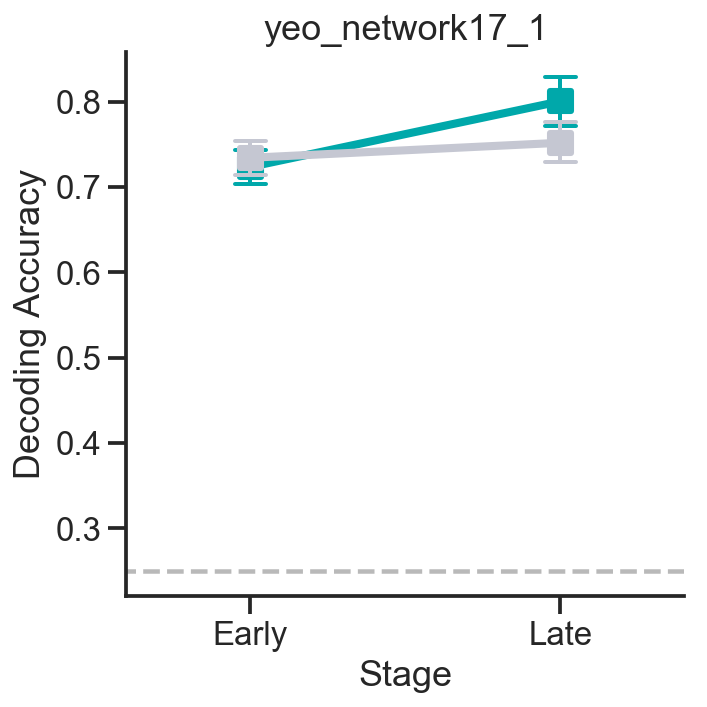

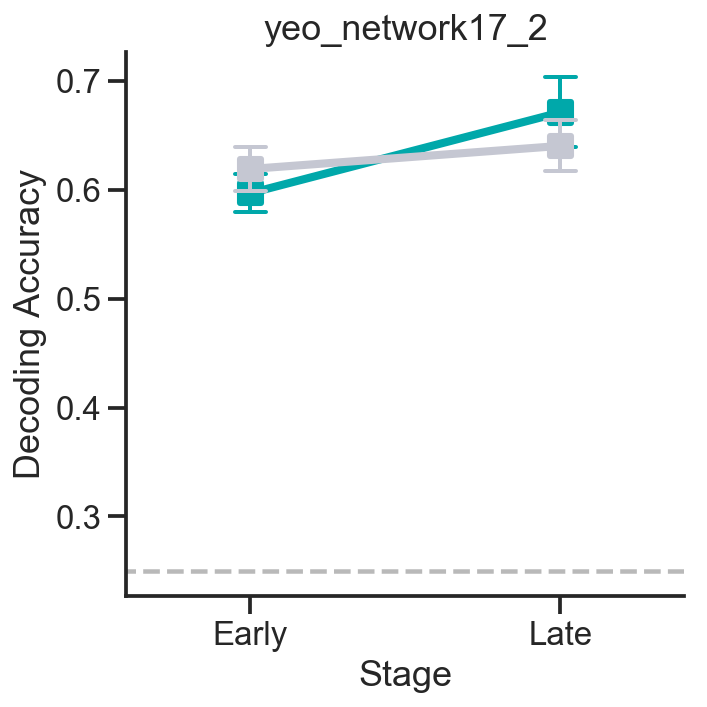

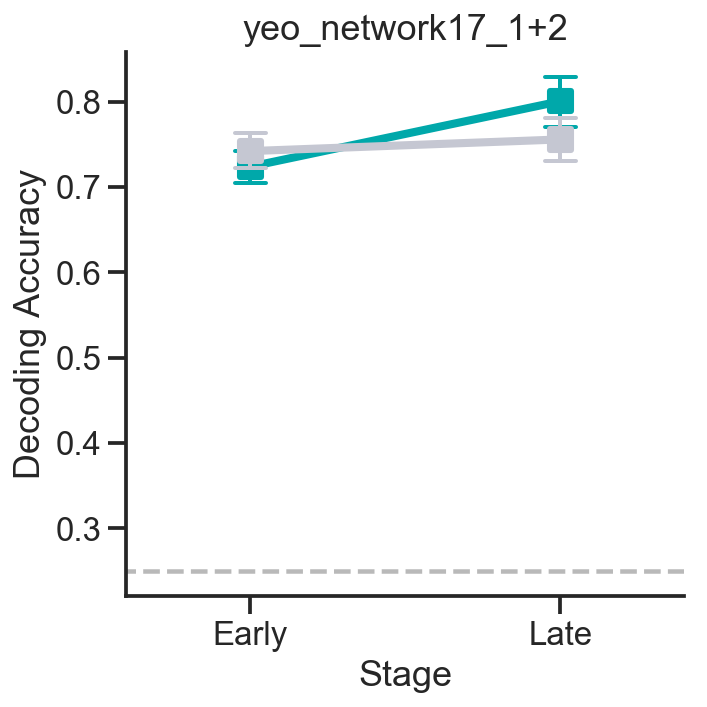

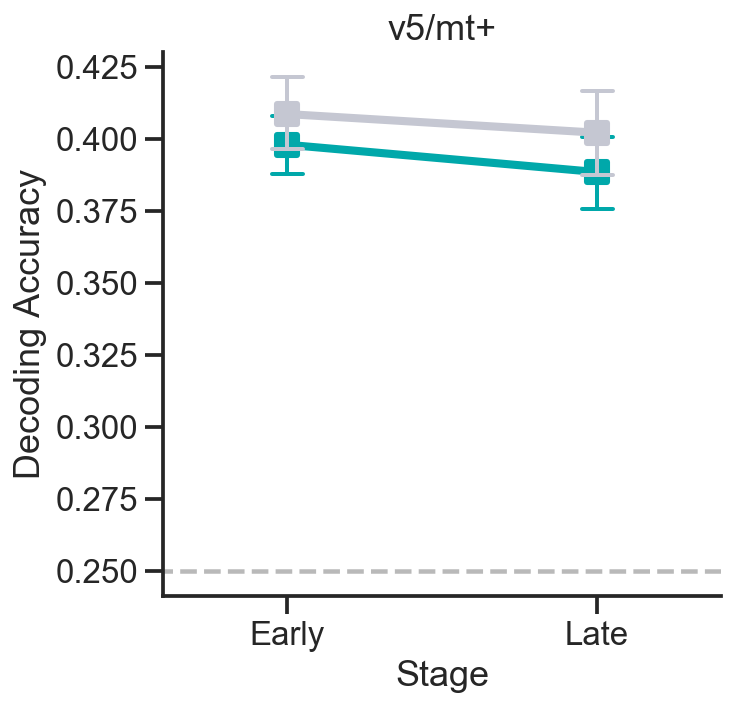

In [59]:
for roi_name, _ in vis_roi_img_list:
    draw_lineplot(roi_name, roi_name)

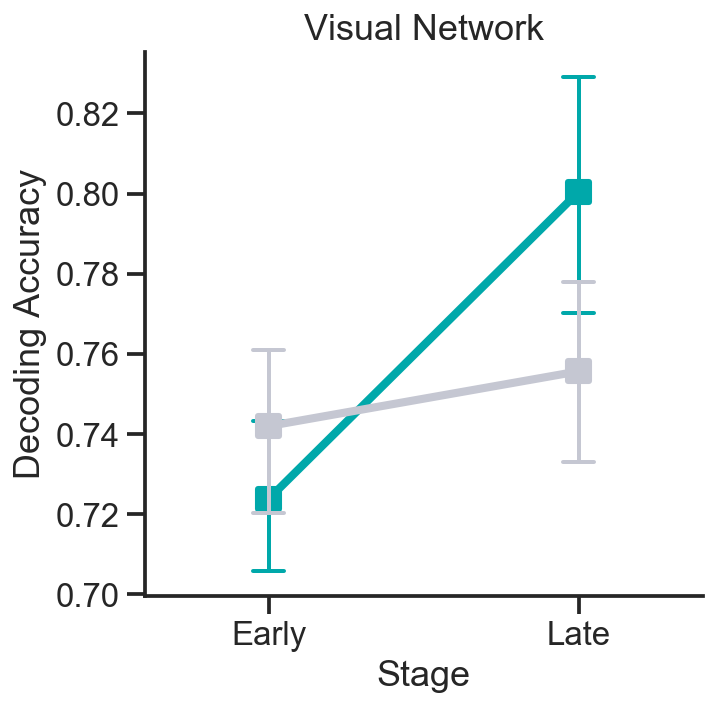

In [62]:
draw_lineplot('yeo_network17_1+2', 'Visual Network')

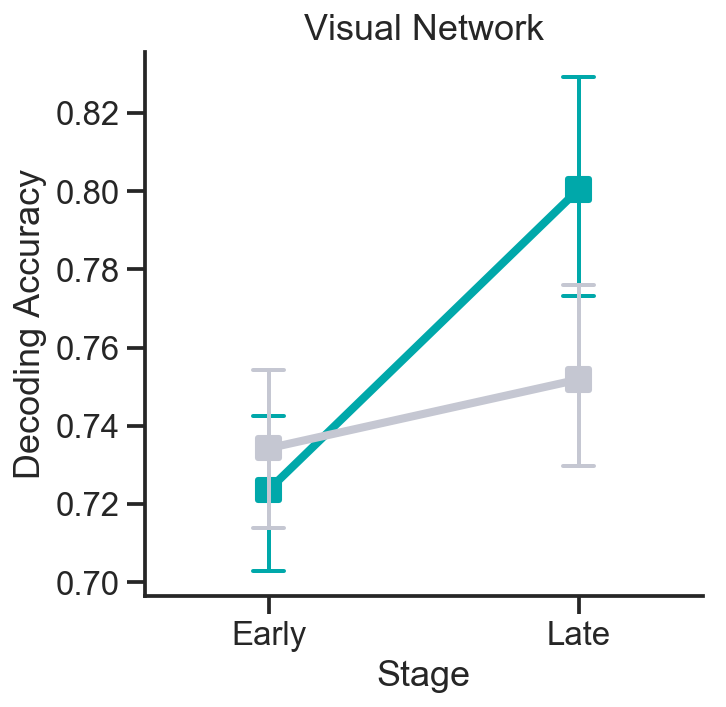

In [82]:
draw_lineplot('yeo_network17_1', 'Visual Network')

In [78]:
sub_df = wit_df[(wit_df['roi_name'] == 'yeo_network17_1+2') & (wit_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
print(res)

Ttest_relResult(statistic=-2.0008607280037496, pvalue=0.05484569182262253)


In [79]:
sub_df = wit_df[(wit_df['roi_name'] == 'yeo_network17_1') & (wit_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
print(res)

Ttest_relResult(statistic=-2.0911730804780535, pvalue=0.0453842147478905)


In [83]:
sub_df = wit_df[(wit_df['roi_name'] == 'v5/mt+') & (wit_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
print(res)

Ttest_relResult(statistic=0.6457003525613104, pvalue=0.5235501605099249)


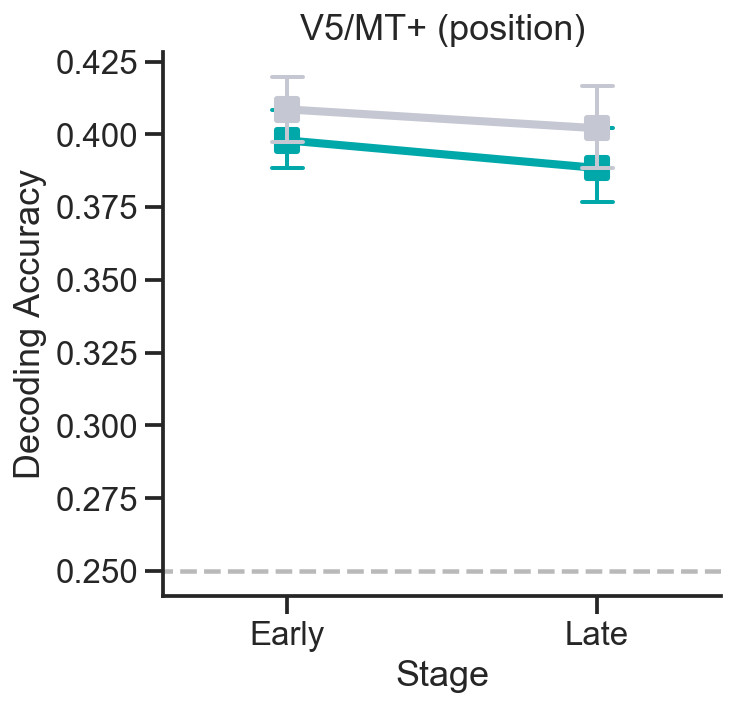

In [72]:
draw_lineplot('v5/mt+', 'V5/MT+ (position)')

In [84]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name, _ in vis_roi_img_list[-1:]:
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['path', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['path', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['path', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['path', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj roi_name      Mapping  Mean Accuracy  Stage
0  GA01   v5/mt+    Practiced       0.218750  Early
1  GA01   v5/mt+    Practiced       0.093750   Late
2  GA01   v5/mt+  Unpracticed       0.225694  Early
3  GA01   v5/mt+  Unpracticed       0.274306   Late
4  GA02   v5/mt+    Practiced       0.135417  Early

In [85]:
sub_df = wit_df[(wit_df['roi_name'] == 'v5/mt+') & (wit_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
print(res)

Ttest_relResult(statistic=-1.413221971413737, pvalue=0.16823476048262168)


In [68]:
def draw_lineplot(roi_name, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', style='roi_name', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/12, 1/12), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    #plt.ylim(0.225, 0.9)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

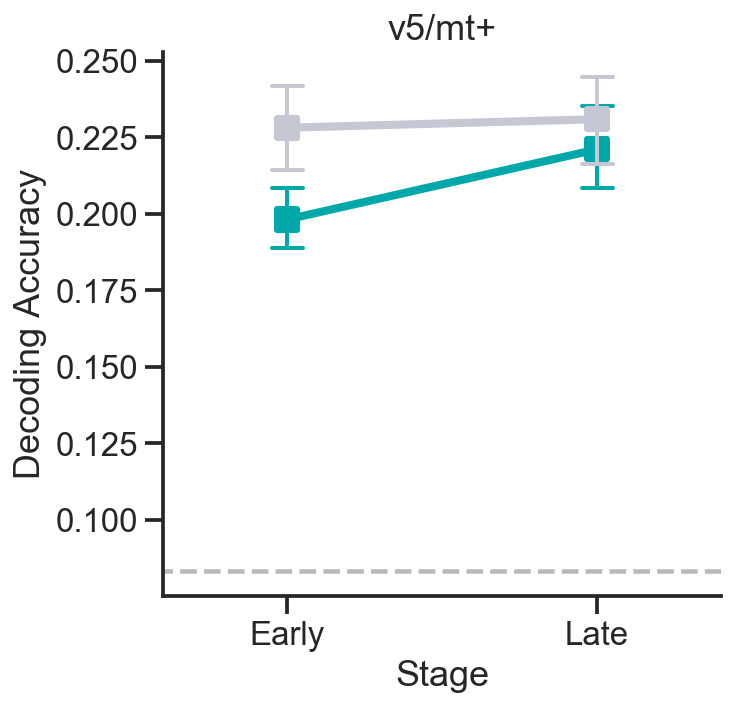

In [55]:
draw_lineplot(roi_name, roi_name)

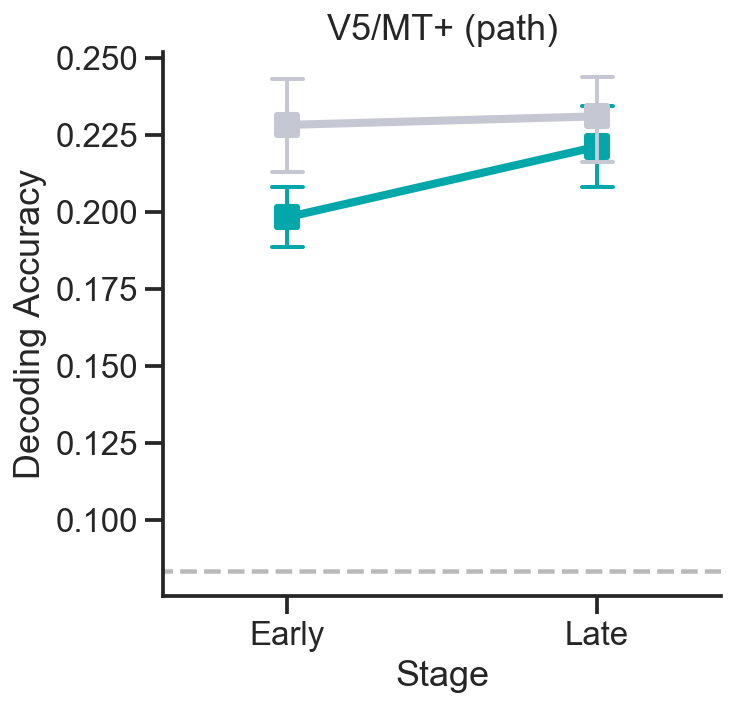

In [69]:
draw_lineplot('v5/mt+', 'V5/MT+ (path)')

# motor(M1/S1 only) / vis (cluster 1) / dmn 간의 univariate connectivity analysis 에서 integration/interaction 와 rew GB-GA 간의 correlation 

In [99]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/DMN/'

module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = {}
roi_names = []

for name in module_names:
    fnames = glob.glob('%s/%s_*.nii' % (roi_dir, name))
    
    #roi_imgs[name] = {}
    
    for fname in fnames:
        roi_name = fname.replace('/Volumes/clmnlab/GA/fmri_data/masks/DMN/', '').replace('.nii', '')
        roi_imgs[roi_name] = nilearn.image.load_img(fname)
        roi_names.append(roi_name)

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [100]:
roi_imgs['motor'] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/glm_results/localizer/20190801/cluster1.nii.gz')
roi_names.append('motor')

In [101]:
for _, row in roi_info.iterrows():
    if row['yeo_17network'] in set([1, 2]):
        roi_imgs['clust%d_'%row['yeo_17network'] + row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append('clust%d_'%row['yeo_17network'] + row['region'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [102]:
roi_names

['Core_aMPFC_r',
 'Core_aMPFC_l',
 'Core_PCC_l',
 'Core_PCC_r',
 'dMsub_TempP_l_temp',
 'dMsub_LTC_l',
 'dMsub_TPJ_r',
 'dMsub_LTC_r',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'dMsub_TPJ_l',
 'MTLsub_PHC_r',
 'MTLsub_vMPFC',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_HF_l',
 'MTLsub_PHC_l',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_HF_r',
 'motor',
 'clust1_FuG_L_3_2',
 'clust1_FuG_R_3_2',
 'clust2_PhG_L_6_6',
 'clust2_PhG_R_6_6',
 'clust2_PCun_L_4_3',
 'clust2_PCun_R_4_3',
 'clust1_MVOcC_L_5_1',
 'clust1_MVOcC_R_5_1',
 'clust2_MVOcC_L_5_2',
 'clust2_MVOcC_R_5_2',
 'clust1_MVOcC_L_5_3',
 'clust1_MVOcC_R_5_3',
 'clust2_MVOcC_L_5_4',
 'clust1_MVOcC_R_5_4',
 'clust2_MVOcC_L_5_5',
 'clust2_MVOcC_R_5_5',
 'clust1_LOcC_L_4_1',
 'clust1_LOcC_R_4_1',
 'clust1_LOcC_L_4_3',
 'clust1_LOcC_R_4_3',
 'clust1_LOcC_L_4_4',
 'clust1_LOcC_R_4_4',
 'clust2_LOcC_L_2_1',
 'clust2_LOcC_R_2_1',
 'clust1_LOcC_L_2_2']

In [103]:
results = {}

for subj in subj_list:
    for roi_name in roi_names:
        
        for run in [1, 2, 3]:
            img = data[subj, run]
            roi_img = roi_imgs[roi_name]
            
            X = fast_masking(roi=roi_img, img=img)
            
            results['practiced', subj, roi_name, run] = np.mean(X, axis=1)
            
        for run in [4, 5, 6]:
            img = data[subj, run]
            roi_img = roi_imgs[roi_name]
            
            X = fast_masking(roi=roi_img, img=img)
            results['unpracticed', subj, roi_name, run] = np.mean(X, axis=1)
        
        print(subj, roi_name, end='\r')

In [104]:
set([len(v) for v in results.values()])

{96}

In [105]:
# helper function for calc mean measure

def mean_score(from_roi, to_roi, *, practiced, late, measure, mean=True):
    i, j = sorted((from_roi, to_roi))

    measures = []
    
    if late == True:
        temp_subj_list = subj_list[30:]
    else:
        temp_subj_list = subj_list[:30]
        
    if practiced == True:
        practiced_str = 'practiced'
        runs = [1, 2, 3]
    else:
        practiced_str = 'unpracticed'
        runs = [4, 5, 6]
    
    for subj in temp_subj_list:
        if measure == 'cosine':
            raise NotImplemented()
        elif measure == 'correlation':
            res = []
            for run in runs:
                coef, _ = scipy.stats.pearsonr(results[practiced_str, subj, i, run], 
                                               results[practiced_str, subj, j, run])
                res.append(coef)
            
            measures.append(np.mean(res))
            
    if mean is True:
        return np.mean(measures)
    else:
        return measures

In [106]:
results2 = {}

for i, from_roi in enumerate(roi_names):
    for j, to_roi in enumerate(roi_names[i+1:]):
        
        score = mean_score(from_roi, to_roi, practiced=True, late=False, measure='correlation', mean=False)
        results2['early', 'practice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=True, late=True, measure='correlation', mean=False)
        results2['late', 'practice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=False, late=False, measure='correlation', mean=False)
        results2['early', 'unpractice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=False, late=True, measure='correlation', mean=False)
        results2['late', 'unpractice', (*sorted((from_roi, to_roi)),)] = score

In [117]:
def integration(rois, *, mapping, stage):
    individual_result = []
    
    for i, from_roi in enumerate(rois):
        for j, to_roi in enumerate(rois[i+1:]):
            individual_result.append(results2[stage, mapping, (*sorted((from_roi, to_roi)),)])
            
    return np.mean(individual_result, axis=0)

In [115]:
dmn_rois = roi_names[:20]
motor_rois = [roi_names[20]]
vis_rois = roi_names[21:]

In [135]:
with open('rew_GB-GA_n30.1D') as file:
    rew_gb_ga = []
    
    for line in file:
        rew_gb_ga.append(float(line.strip()))

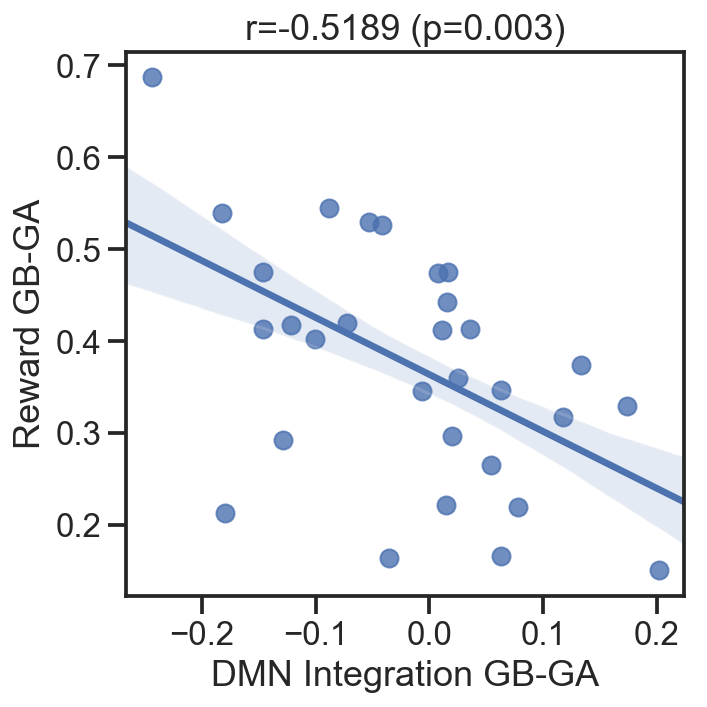

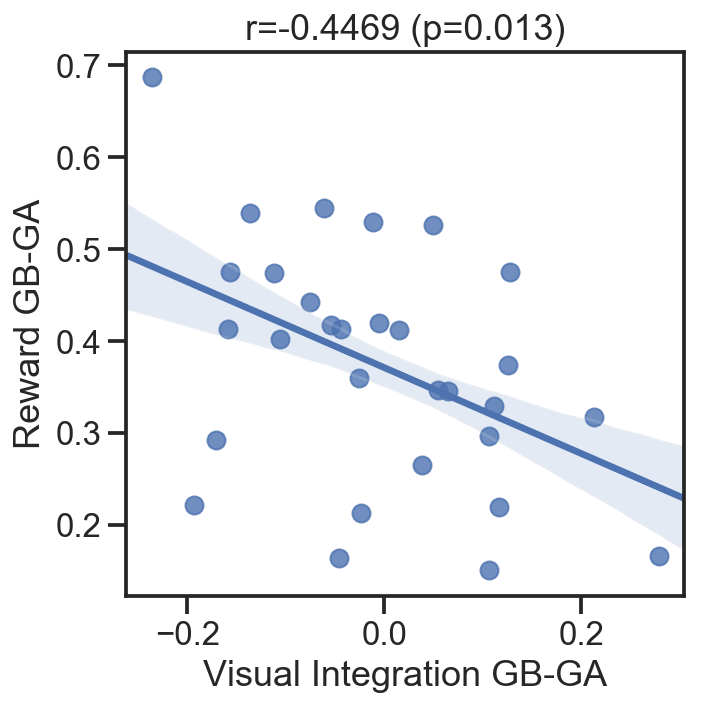

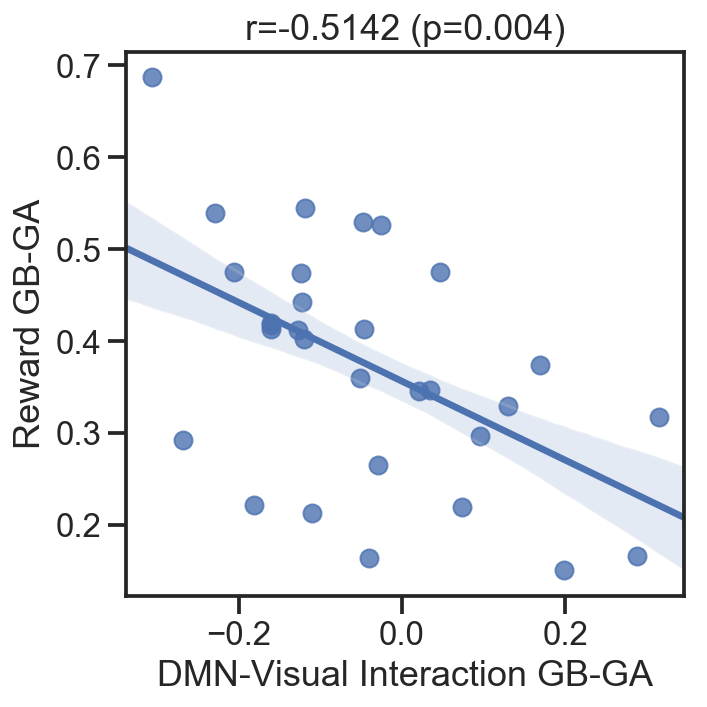

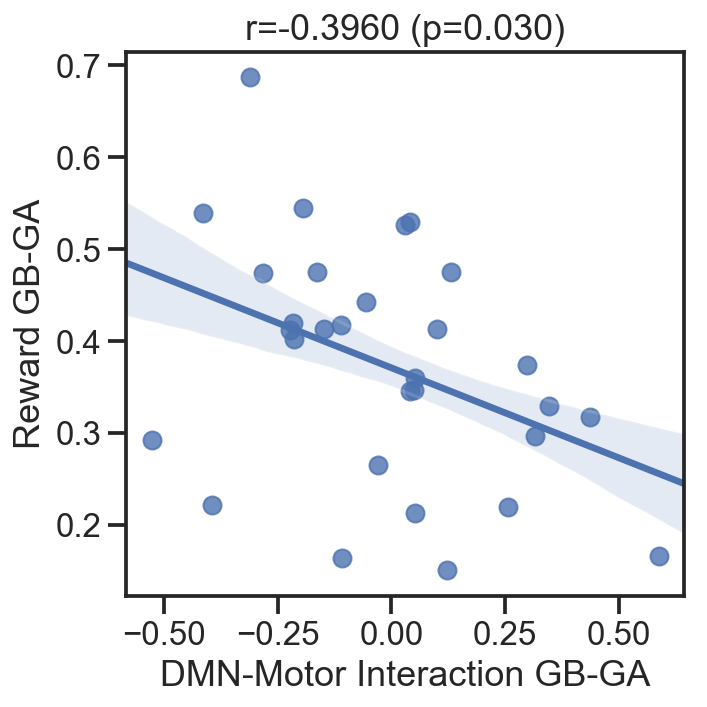

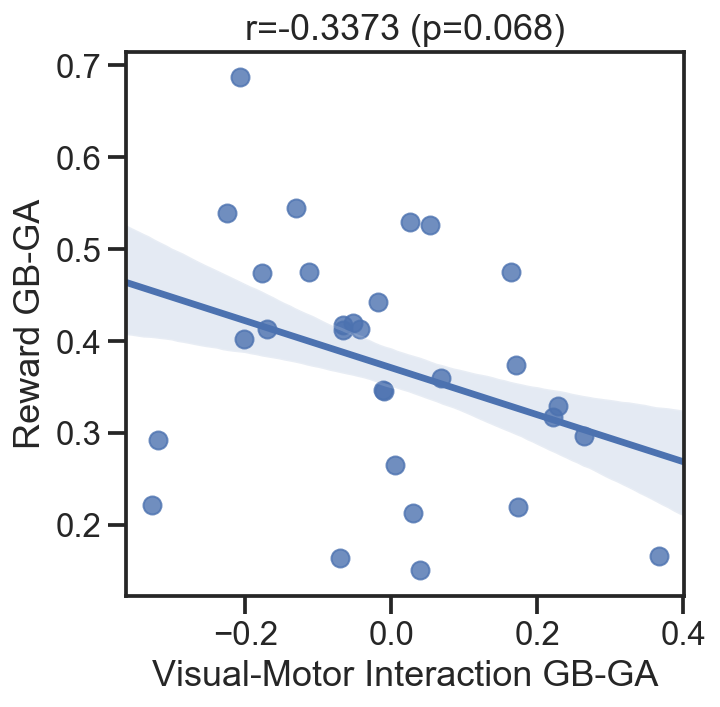

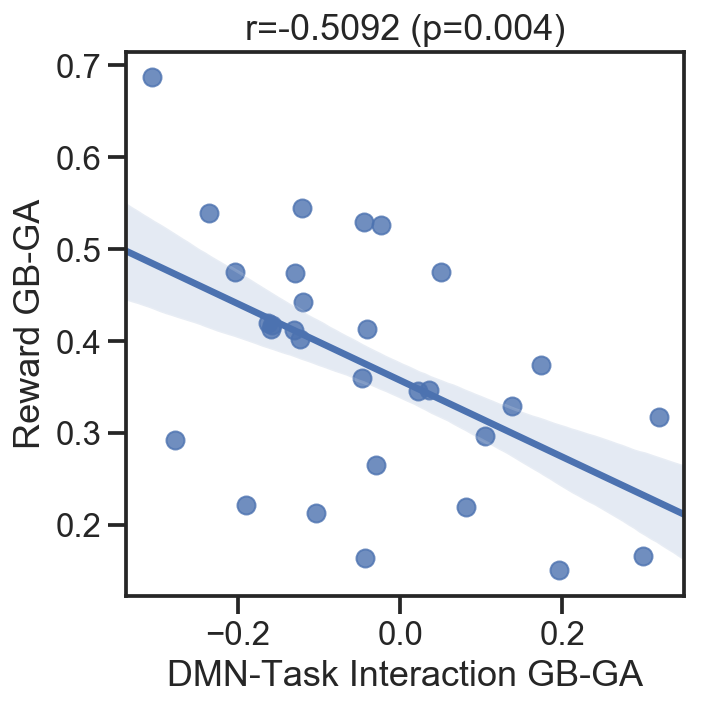

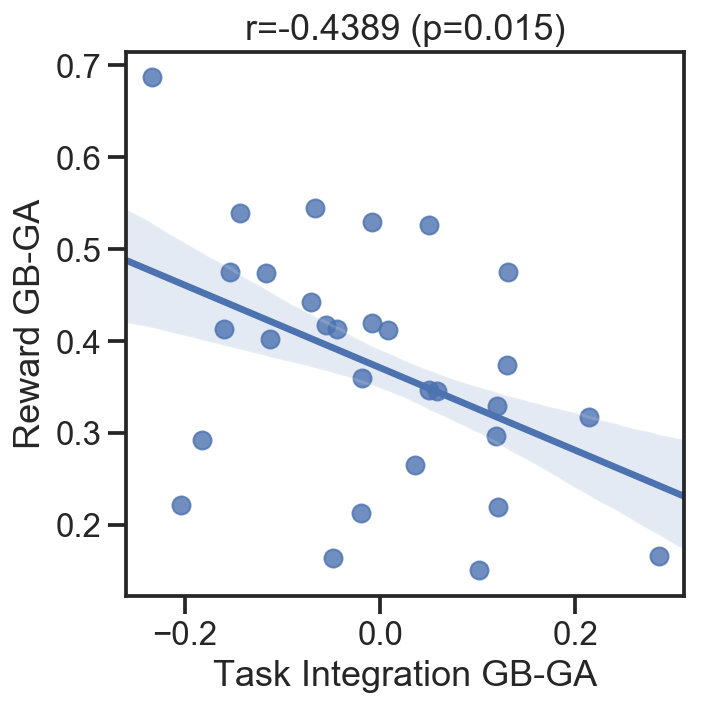

In [154]:
def draw_scatter(x, name):
    plt.figure(figsize=(5, 5))
    df = pd.DataFrame([rew_gb_ga, x])
    df = df.transpose()
    df.columns = ['reward', 'x']
    sns.regplot(data=df, x='x', y='reward', ci=68)
    plt.ylabel('Reward GB-GA')
    plt.xlabel('%s GB-GA' % name)
    plt.title('r=%.4f (p=%.3f)' % (*scipy.stats.pearsonr(x=x, y=rew_gb_ga),))
    #plt.xlim(-0.65, 0.65)
    plt.show()
    
def draw_integration(rois, name):
    x = integration(rois, mapping='practice', stage='late') - integration(rois, mapping='practice', stage='early')
    draw_scatter(x, name)
    
def draw_interaction(rois1, rois2, name):
    x = interaction(rois1, rois2, mapping='practice', stage='late') - interaction(rois1, rois2, mapping='practice', stage='early')
    draw_scatter(x, name)


# 1, 1
#ax = plt.subplot(3, 3, 1)
draw_integration(dmn_rois, 'DMN Integration')

# 2, 2
#ax = plt.subplot(3, 3, 5)
draw_integration(vis_rois, 'Visual Integration')

# 3, 3
#ax = plt.subplot(3, 3, 9)
#draw_integration(mot_rois, 'Sensorimotor Integration')

# 1, 2
#ax = plt.subplot(3, 3, 2)
draw_interaction(dmn_rois, vis_rois, 'DMN-Visual Interaction')

# 1, 3
#ax = plt.subplot(3, 3, 3)
draw_interaction(dmn_rois, motor_rois, 'DMN-Motor Interaction')

# 2, 3
#ax = plt.subplot(3, 3, 6)
draw_interaction(vis_rois, motor_rois, 'Visual-Motor Interaction')

# 3, 1
#ax = plt.subplot(3, 3, 7)
draw_interaction(dmn_rois, vis_rois+motor_rois, 'DMN-Task Interaction')


# 3, 2
#ax = plt.subplot(3, 3, 8)
draw_integration(vis_rois+motor_rois, 'Task Integration')

# Localizer 안에서의 integration

In [159]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/DMN/'

module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = {}
roi_names = []

for name in module_names:
    fnames = glob.glob('%s/%s_*.nii' % (roi_dir, name))
    
    #roi_imgs[name] = {}
    
    for fname in fnames:
        roi_name = fname.replace('/Volumes/clmnlab/GA/fmri_data/masks/DMN/', '').replace('.nii', '')
        roi_imgs[roi_name] = nilearn.image.load_img(fname)
        roi_names.append(roi_name)

for path in roi_path:
    roi_imgs[path.split('/')[-1].replace('_mask.nii', '')] = (nilearn.image.load_img(path))
    roi_names.append(path.split('/')[-1].replace('_mask.nii', ''))
    
for _, row in roi_info.iterrows():
    if row['yeo_17network'] in set([1, 2]):
        roi_imgs['clust%d_'%row['yeo_17network'] + row['region']] = nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label']))
        roi_names.append('clust%d_'%row['yeo_17network'] + row['region'])

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [163]:
dmn_rois = roi_names[:20]
motor_rois = roi_names[20:27]
vis_rois = roi_names[27:]

In [166]:
results = {}

for subj in subj_list:
    for roi_name in roi_names:
        
        for run in [1, 2, 3]:
            img = data[subj, run]
            roi_img = roi_imgs[roi_name]
            
            X = fast_masking(roi=roi_img, img=img)
            
            results['practiced', subj, roi_name, run] = np.mean(X, axis=1)
            
        for run in [4, 5, 6]:
            img = data[subj, run]
            roi_img = roi_imgs[roi_name]
            
            X = fast_masking(roi=roi_img, img=img)
            results['unpracticed', subj, roi_name, run] = np.mean(X, axis=1)
        
        print(subj, roi_name, end='\r')

In [167]:
results2 = {}

for i, from_roi in enumerate(roi_names):
    for j, to_roi in enumerate(roi_names[i+1:]):
        
        score = mean_score(from_roi, to_roi, practiced=True, late=False, measure='correlation', mean=False)
        results2['early', 'practice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=True, late=True, measure='correlation', mean=False)
        results2['late', 'practice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=False, late=False, measure='correlation', mean=False)
        results2['early', 'unpractice', (*sorted((from_roi, to_roi)),)] = score
        
        score = mean_score(from_roi, to_roi, practiced=False, late=True, measure='correlation', mean=False)
        results2['late', 'unpractice', (*sorted((from_roi, to_roi)),)] = score

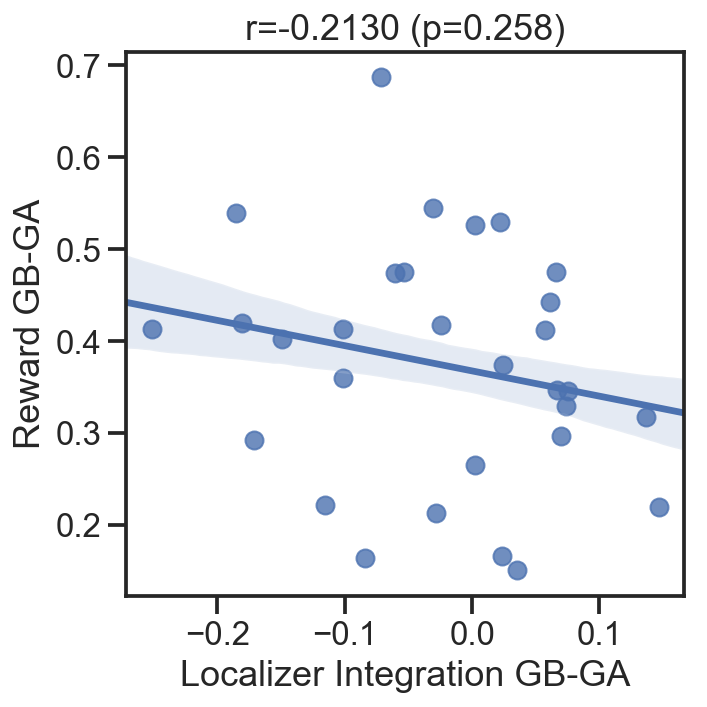

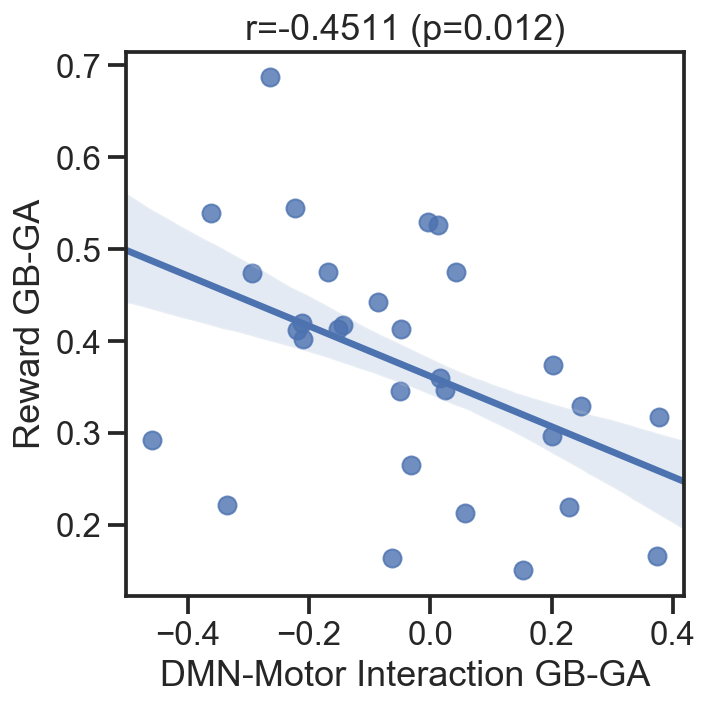

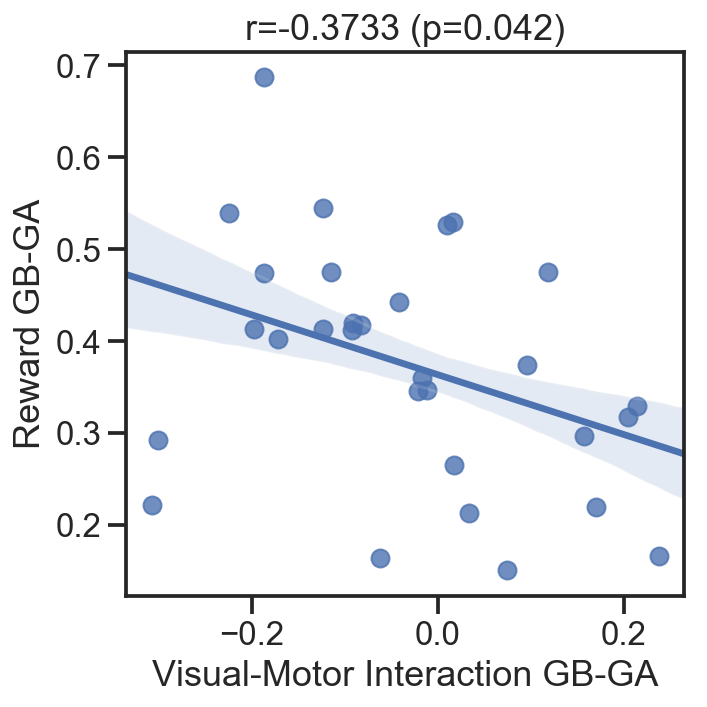

In [168]:
draw_integration(motor_rois, 'Localizer Integration')

draw_interaction(dmn_rois, motor_rois, 'DMN-Motor Interaction')

draw_interaction(vis_rois, motor_rois, 'Visual-Motor Interaction')

In [179]:
sub_df = wit_df[(wit_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
print(res)

Ttest_relResult(statistic=1.1051361567866413, pvalue=0.2781853683500149)
